# <font color="red">Conditions Prediction with Light GBM Classifier</font>

# Import Library

In [1]:
# Data manipulation and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import json
from contextlib import redirect_stdout, redirect_stderr
import io

# Preprocessing
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from lightgbm import LGBMClassifier
from sklearn.ensemble import BaggingClassifier

import sys
sys.path.append('../../') # Uncomment this line if running locally
# sys.path.append('/kaggle/input/weatherdata') # Uncomment this line if running on Kaggle
from historyManagement import *

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Datasets Import

In [2]:
# Load the weather dataset for visibility prediction
weather_data = pd.read_csv('../../FinalDatasets/finalDataset.csv') # Uncomment this line if running locally
# weather_data = pd.read_csv('/kaggle/input/weatherdata/finalDataset.csv') # Uncomment this line if running on Kaggl
weather_data['DateTime'] = pd.to_datetime(weather_data['DateTime'])
weather_data.head()

,DateTime,Year,Month,Day,Hour,DaySegments,DaySegments_Afternoon,DaySegments_Early Morning,DaySegments_Evening,DaySegments_Late Night,...,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk,Visibility,SolarRadiation,SolarEnergy,Conditions,Icon
0,2023-01-01 00:00:00,2023,1,1,0,Late Night,0,0,0,1,...,0.49,1018.68,0.03,0.0,10.0,2.76,0.0,0.0,Clear,clear-night
1,2023-01-01 01:00:00,2023,1,1,1,Late Night,0,0,0,1,...,0.54,1018.03,0.11,0.0,10.0,1.75,0.0,0.0,Clear,clear-night
2,2023-01-01 02:00:00,2023,1,1,2,Late Night,0,0,0,1,...,30.51,1017.56,0.03,0.0,10.0,1.75,0.0,0.0,Clear,clear-night
3,2023-01-01 03:00:00,2023,1,1,3,Late Night,0,0,0,1,...,49.23,1018.05,0.00,0.0,10.0,2.28,0.0,0.0,Clear,clear-night
4,2023-01-01 04:00:00,2023,1,1,4,Late Night,0,0,0,1,...,49.90,1018.00,86.17,0.0,10.0,1.27,0.0,0.0,Partially cloudy,fog


In [3]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

In [4]:
weather_data.describe()

,DateTime,Year,Month,Day,Hour,DaySegments_Afternoon,DaySegments_Early Morning,DaySegments_Evening,DaySegments_Late Night,DaySegments_Midday,...,Windgust,WindSpeed,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk,Visibility,SolarRadiation,SolarEnergy
count,14616,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,...,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000,14616.000000
mean,2023-11-01 11:30:00,2023.400657,5.720854,15.735632,11.500000,0.131294,0.060550,0.098043,0.249726,0.116585,...,17.068560,8.090783,159.739178,1008.265012,53.579923,2.263555,16.504787,4.368134,227.640683,0.819217
min,2023-01-01 00:00:00,2023.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.660000,0.000000,0.000000,982.420000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000
25%,2023-06-02 05:45:00,2023.000000,3.000000,8.000000,5.750000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.170000,2.870000,80.965000,1003.277500,26.670000,0.000000,10.000000,3.990000,0.000000,0.000000
50%,2023-11-01 11:30:00,2023.000000,6.000000,16.000000,11.500000,0.000000,0.000000,0.000000,0.000000,0.000000,...,14.645000,7.670000,163.790000,1007.970000,51.540000,0.000000,10.000000,4.650000,10.665000,0.010000
75%,2024-04-01 17:15:00,2024.000000,8.000000,23.000000,17.250000,0.000000,0.000000,0.000000,0.000000,0.000000,...,23.410000,11.750000,241.402500,1013.400000,87.790000,4.740000,12.580000,4.650000,459.745000,1.660000
max,2024-08-31 23:00:00,2024.000000,12.000000,31.000000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,84.120000,71.970000,360.000000,1022.060000,100.000000,10.000000,97.740000,24.100000,1026.650000,3.700000
std,NaN,0.490048,3.195073,8.803610,6.922423,0.337734,0.238511,0.297383,0.432869,0.320936,...,10.195911,6.250203,104.422027,6.010683,35.166637,3.083074,15.031827,1.376994,307.219387,1.106444


# Data Split

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_idx, test_idx in sss.split(weather_data, weather_data['Conditions']):
    weather_data_train = weather_data.iloc[train_idx]
    weather_data_test = weather_data.iloc[test_idx]

In [6]:
# Show the count of each unique class in Conditions
class_counts = weather_data['Conditions'].value_counts().reset_index()
class_counts.columns = ['Conditions', 'Count']

print("Distribution of data based on Conditions:")
print(class_counts)

Distribution of data based on Conditions:
               Conditions  Count
0        Partially cloudy   7785
1                   Clear   3316
2  Rain, Partially cloudy   2118
3          Rain, Overcast    746
4                Overcast    629
5                    Rain     22


In [7]:
print("Distribution of Conditions in Training Set:")
print(weather_data_train['Conditions'].value_counts())

print("\nDistribution of Conditions in Test Set:")
print(weather_data_test['Conditions'].value_counts())

Distribution of Conditions in Training Set:
Conditions
Partially cloudy          6227
Clear                     2653
Rain, Partially cloudy    1694
Rain, Overcast             597
Overcast                   503
Rain                        18
Name: count, dtype: int64

Distribution of Conditions in Test Set:
Conditions
Partially cloudy          1558
Clear                      663
Rain, Partially cloudy     424
Rain, Overcast             149
Overcast                   126
Rain                         4
Name: count, dtype: int64


# Some Reused Parameters

In [8]:
grid_param = {
    'max_depth': [-1, 3, 5, 7, 10],
    'num_leaves': [31, 50, 100, 150, 200],
    'min_child_samples': [20, 50, 100, 200],
    'min_child_weight': [0.001, 0.01, 0.1],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0],
    'feature_fraction': [0.8, 0.9, 1.0],
    'bagging_fraction': [0.8, 0.9, 1.0],
    'bagging_freq': [0, 1, 5],
    'min_split_gain': [0.0, 0.1, 0.2],
    'subsample_for_bin': [200000, 300000, 500000],
}

In [9]:
number_of_model_for_randomized_grid = 350
model_name_for_saving = "Light GBM"
target_name_for_saving = "Conditions"
number_of_model_for_bagging = 100

# All Features

In [10]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_train = weather_data_train['Conditions']

In [11]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon']) # Target variable
y_test = weather_data_test['Conditions']

In [12]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [13]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2924
y_test:  2924


## MinMax Scaler

In [14]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Convert back to DataFrame to preserve feature names
X_train = pd.DataFrame(X_train_scaled, columns=X_train_raw.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)

# Clean column names - replace spaces with underscores
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

In [15]:
print(X_train.columns.tolist())

['Month', 'Day', 'Hour', 'DaySegments_Afternoon', 'DaySegments_Early_Morning', 'DaySegments_Evening', 'DaySegments_Late_Night', 'DaySegments_Midday', 'DaySegments_Morning', 'DaySegments_Night', 'Season_Autumn', 'Season_Rainy', 'Season_Summer', 'Season_Winter', 'Temp', 'FeelsLike', 'Dew', 'Humidity', 'Precip', 'PrecipProb', 'Windgust', 'WindSpeed', 'WindDir', 'SeaLevelPressure', 'CloudCover', 'UVIndex', 'SevereRisk']


In [16]:
X_train

,Month,Day,Hour,DaySegments_Afternoon,DaySegments_Early_Morning,DaySegments_Evening,DaySegments_Late_Night,DaySegments_Midday,DaySegments_Morning,DaySegments_Night,...,Humidity,Precip,PrecipProb,Windgust,WindSpeed,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk
0,0.818182,0.466667,0.695652,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.430377,0.000000,0.0000,0.078481,0.002084,0.026750,0.645308,0.4906,0.319,0.089508
1,0.272727,0.166667,0.869565,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.579161,0.000000,0.0000,0.375629,0.205224,0.455167,0.568870,0.5161,0.000,0.684399
2,1.000000,0.300000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.800548,0.000000,0.0000,0.172538,0.004724,0.962722,0.776741,0.3604,0.000,0.073886
3,0.272727,0.033333,0.782609,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.440749,0.000000,0.0000,0.219147,0.105183,0.628056,0.552472,0.6147,0.094,0.073886
4,0.000000,0.800000,0.608696,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.568550,0.000000,0.0000,0.004673,0.129776,0.208333,0.897578,0.8940,0.700,0.073886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11687,0.818182,0.933333,0.478261,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.489151,0.000000,0.0000,0.080637,0.140058,0.937806,0.785318,0.0129,0.797,0.073886
11688,0.727273,0.333333,0.782609,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.770744,0.004944,0.9677,0.180206,0.071419,0.561444,0.460898,0.6713,0.097,0.284991
11689,0.272727,0.833333,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.512399,0.000000,0.0000,0.102205,0.037377,0.829944,0.672805,0.2311,0.000,0.073886
11690,0.181818,0.533333,0.347826,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.804006,0.000000,0.0000,0.091661,0.152980,0.977611,0.773209,0.8811,0.197,0.020477


In [17]:
X_test

,Month,Day,Hour,DaySegments_Afternoon,DaySegments_Early_Morning,DaySegments_Evening,DaySegments_Late_Night,DaySegments_Midday,DaySegments_Morning,DaySegments_Night,...,Humidity,Precip,PrecipProb,Windgust,WindSpeed,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk
0,0.181818,0.400000,0.521739,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.367907,0.000000,0.0000,0.259166,0.094762,0.547417,0.775984,0.2298,0.900,0.073886
1,0.727273,0.066667,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.649857,0.000899,0.1935,0.215912,0.141031,0.498444,0.518416,0.8872,0.000,0.080747
2,0.454545,0.566667,0.739130,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.804125,0.000449,0.0968,0.389288,0.177018,0.248833,0.390262,0.8894,0.206,0.584653
3,0.454545,0.066667,0.869565,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.734263,0.013034,0.9677,0.361011,0.304849,0.356611,0.541120,0.8712,0.000,0.278130
4,0.272727,0.800000,0.304348,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.677158,0.000000,0.0000,0.197819,0.131583,0.481472,0.568870,0.0000,0.197,0.113046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2919,0.727273,0.600000,0.217391,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.866595,0.070787,1.0000,0.293554,0.154926,0.249028,0.568870,0.8790,0.000,0.071459
2920,0.454545,0.800000,0.478261,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.612184,0.000225,0.0968,0.142224,0.157010,0.546583,0.491927,0.5097,0.890,0.284991
2921,0.272727,0.766667,0.826087,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.499404,0.000000,0.0323,0.212916,0.130749,0.834500,0.671292,0.8816,0.000,0.061959
2922,0.727273,0.433333,0.869565,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.696471,0.000000,0.0000,0.409058,0.229123,0.409222,0.568113,0.8825,0.000,0.094364


### Default Parameters

In [18]:
training_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')

training_model

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [19]:
%%time
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    training_model.fit(X_train, y_train)

CPU times: total: 2.31 s
Wall time: 2.19 s


In [20]:
y_pred = training_model.predict(X_test)
y_pred

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype=object)

In [21]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [22]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [23]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9925
Precision: 0.9928
Recall:    0.9925
F1-Score:  0.9925


In [24]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.98      0.99       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.99      1.00      0.99      1558
                  Rain       0.67      1.00      0.80         4
        Rain, Overcast       0.99      0.99      0.99       149
Rain, Partially cloudy       1.00      0.99      0.99       424

              accuracy                           0.99      2924
             macro avg       0.94      0.99      0.96      2924
          weighted avg       0.99      0.99      0.99      2924



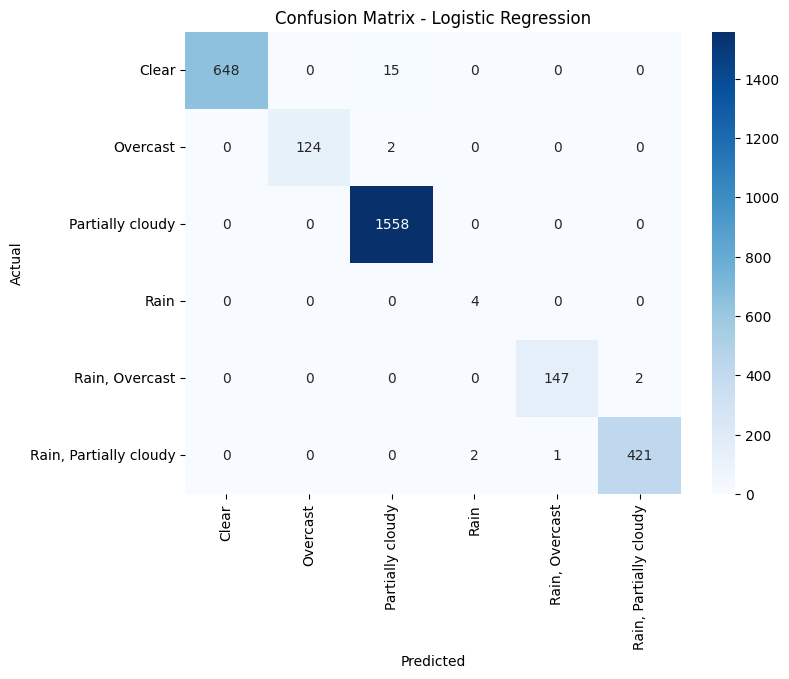

In [25]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [26]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [27]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [28]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9998
Overcast : 0.9969
Partially cloudy : 0.9994
Rain     : 0.9995
Rain, Overcast : 0.9942
Rain, Partially cloudy : 0.9948
Micro-avg : 0.9985


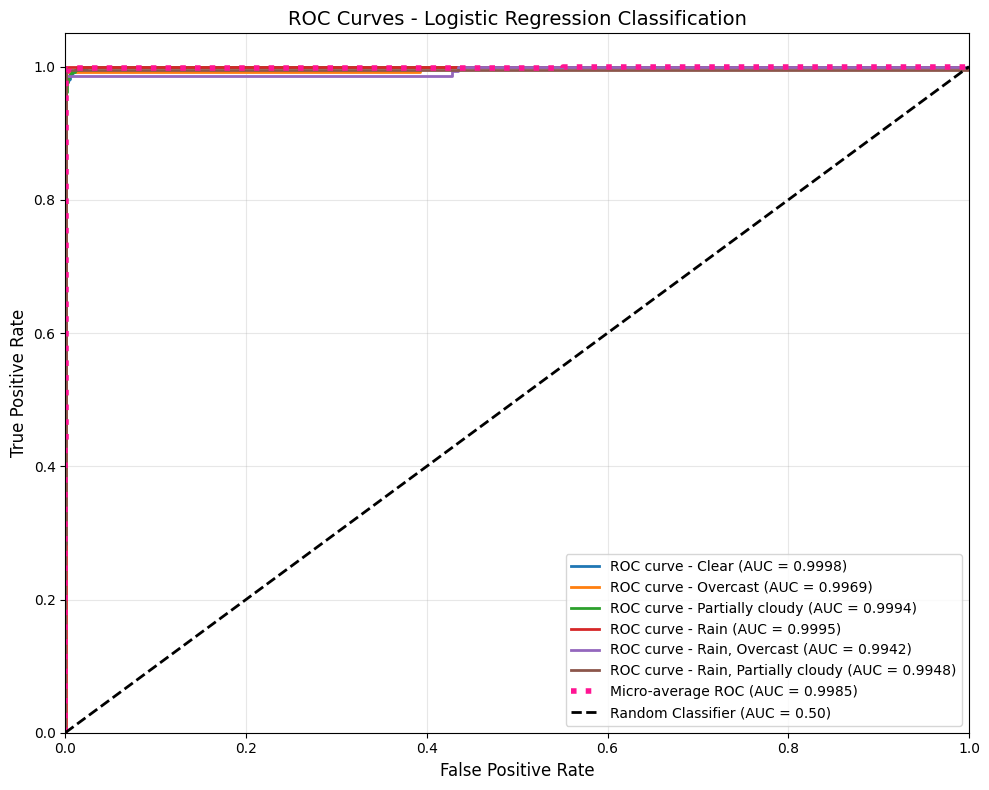

In [29]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [30]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9985
One-vs-One (Weighted)  : 0.9978
Micro-average          : 0.9985


In [31]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.992476, F1: 0.992525, AUC (micro-avg): 0.998495
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [32]:
grid_search = RandomizedSearchCV(
    LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass'), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

,estimator,LGBMClassifie... verbose=0)
,param_distributions,"{'bagging_fraction': [0.8, 0.9, ...], 'bagging_freq': [0, 1, ...], 'feature_fraction': [0.8, 0.9, ...], 'learning_rate': [0.01, 0.05, ...], ...}"
,n_iter,350
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [33]:
%%time
print("Starting Grid Search...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    grid_search.fit(X_train, y_train)

Starting Grid Search...
CPU times: total: 13.7 s
Wall time: 16min 53s


In [34]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'subsample_for_bin': 500000, 'reg_lambda': 0.0, 'reg_alpha': 0.1, 'num_leaves': 31, 'n_estimators': 300, 'min_split_gain': 0.0, 'min_child_weight': 0.1, 'min_child_samples': 200, 'max_depth': 5, 'learning_rate': 0.2, 'feature_fraction': 1.0, 'bagging_freq': 0, 'bagging_fraction': 0.9}
Best Cross-Validation Score: 0.9954255168653283


In [35]:
y_pred_grid = best_grid_model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [36]:
y_pred_grid

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype=object)

In [37]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [38]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [39]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9932
Precision: 0.9932
Recall:    0.9932
F1-Score:  0.9931


In [40]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.98      0.99       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.99      1.00      0.99      1558
                  Rain       1.00      1.00      1.00         4
        Rain, Overcast       0.99      0.99      0.99       149
Rain, Partially cloudy       1.00      1.00      1.00       424

              accuracy                           0.99      2924
             macro avg       1.00      0.99      0.99      2924
          weighted avg       0.99      0.99      0.99      2924



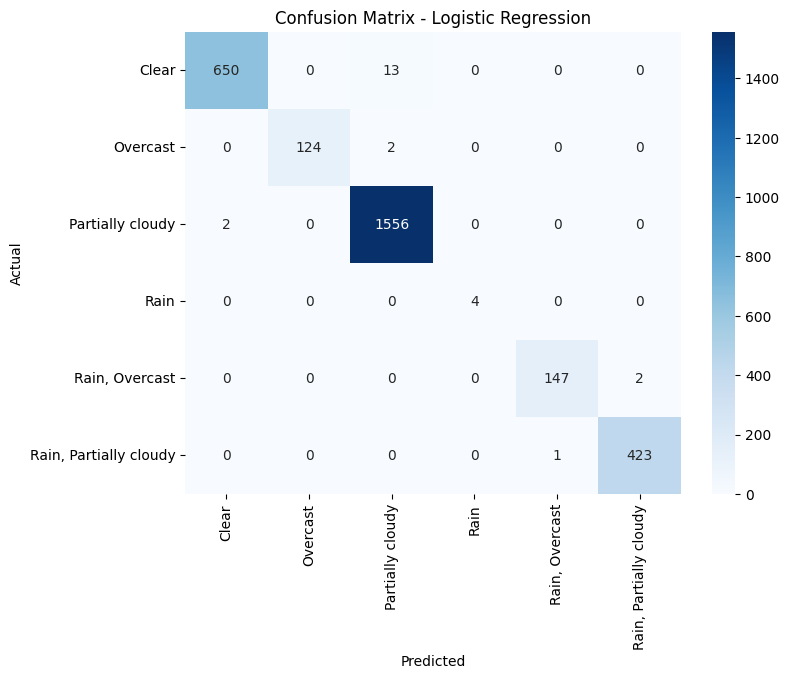

In [41]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [42]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [43]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [44]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9998
Overcast : 0.9991
Partially cloudy : 0.9997
Rain     : 1.0000
Rain, Overcast : 0.9949
Rain, Partially cloudy : 0.9996
Micro-avg : 0.9996


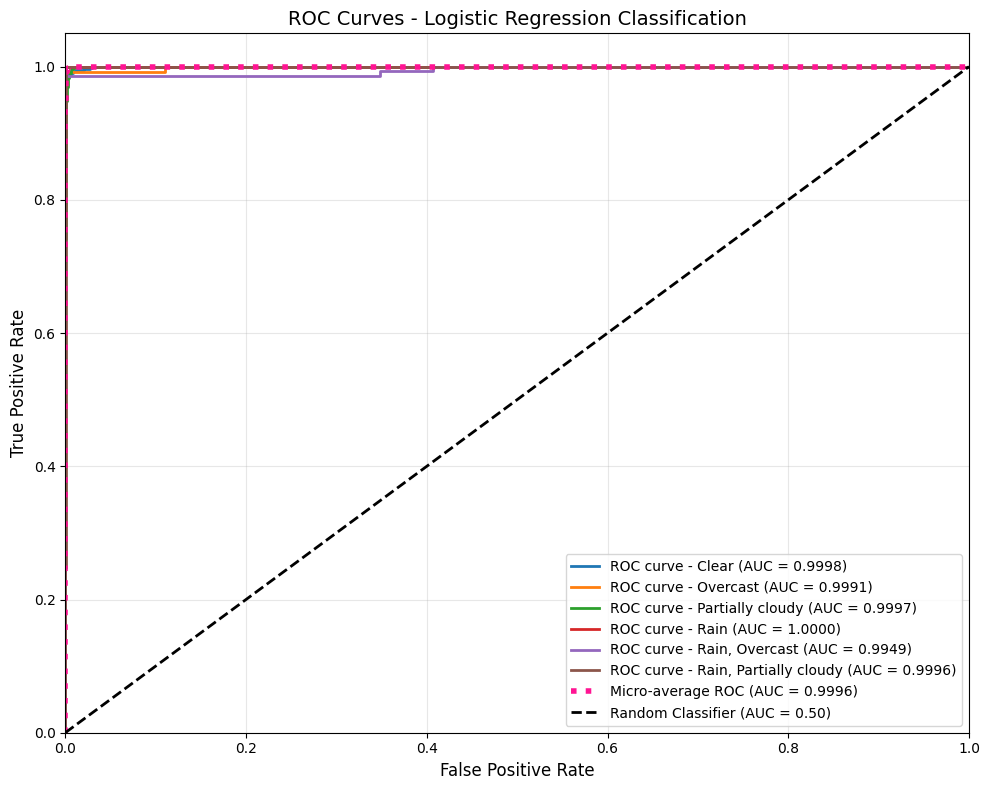

In [45]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [46]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9994
One-vs-One (Weighted)  : 0.9988
Micro-average          : 0.9996


In [47]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.993160, F1: 0.993147, AUC (micro-avg): 0.999567
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [48]:
base_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
base_model

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [49]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

,estimator,LGBMClassifie... verbose=0)
,n_estimators,100
,max_samples,1.0
,max_features,0.8
,bootstrap,True
,bootstrap_features,True
,oob_score,False
,warm_start,False
,n_jobs,-1
,random_state,42
,verbose,1


In [50]:
%%time
print("Starting Bagging Ensemble...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    bagging_clf.fit(X_train, y_train)

Starting Bagging Ensemble...
CPU times: total: 5.36 s
Wall time: 1min 7s


In [51]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.4s remaining:    7.3s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.6s finished


In [52]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [53]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9925
Precision: 0.9925
Recall:    0.9925
F1-Score:  0.9925


In [54]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.98      0.99       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.99      1.00      0.99      1558
                  Rain       1.00      1.00      1.00         4
        Rain, Overcast       1.00      0.98      0.99       149
Rain, Partially cloudy       0.99      1.00      1.00       424

              accuracy                           0.99      2924
             macro avg       1.00      0.99      0.99      2924
          weighted avg       0.99      0.99      0.99      2924



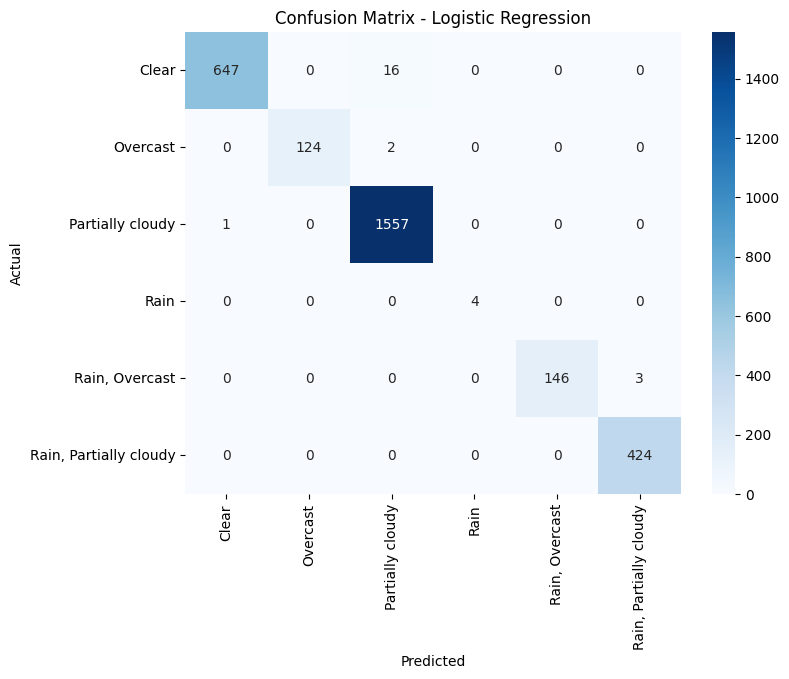

In [55]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [56]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.5s remaining:    7.6s


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.7s finished


In [57]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [58]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9989
Overcast : 0.9999
Partially cloudy : 0.9990
Rain     : 1.0000
Rain, Overcast : 0.9993
Rain, Partially cloudy : 0.9996
Micro-avg : 0.9993


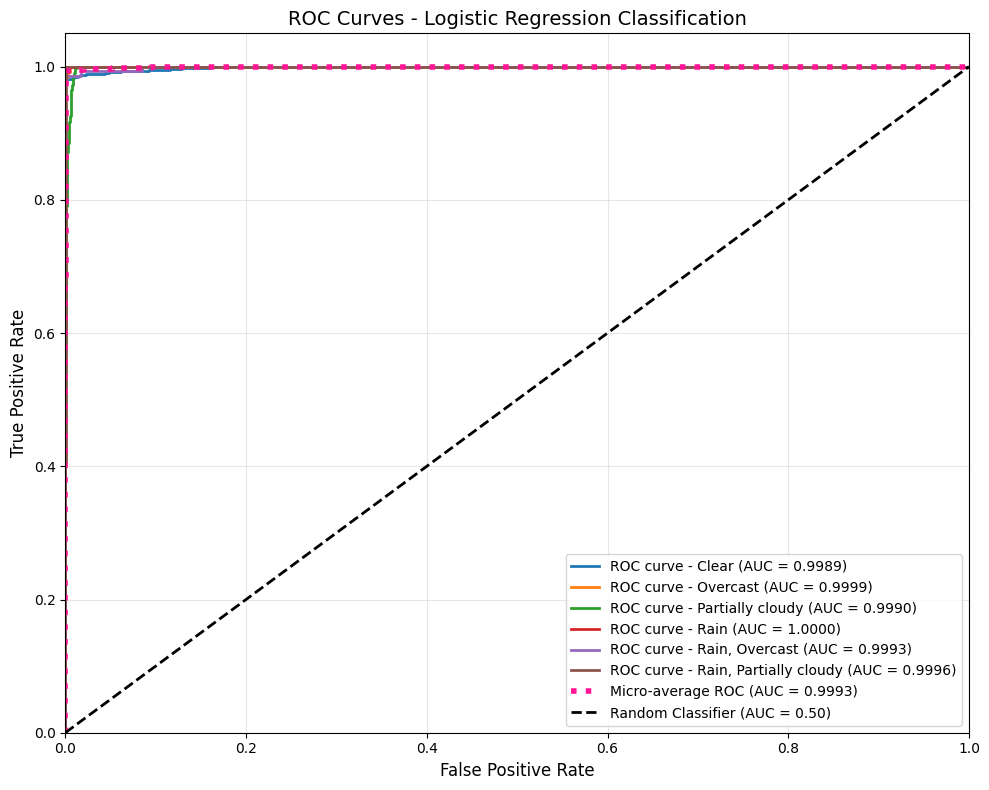

In [59]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [60]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9991
One-vs-One (Weighted)  : 0.9992
Micro-average          : 0.9993


In [61]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.992476, F1: 0.992454, AUC (micro-avg): 0.999328
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


## Standard Scaler

In [62]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Convert back to DataFrame to preserve feature names
X_train = pd.DataFrame(X_train_scaled, columns=X_train_raw.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)

# Clean column names - replace spaces with underscores
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

In [63]:
X_train

,Month,Day,Hour,DaySegments_Afternoon,DaySegments_Early_Morning,DaySegments_Evening,DaySegments_Late_Night,DaySegments_Midday,DaySegments_Morning,DaySegments_Night,...,Humidity,Precip,PrecipProb,Windgust,WindSpeed,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk
0,1.344591,-0.087981,0.644438,2.544740,-0.249272,-0.330921,-0.574453,-0.36552,-0.560228,-0.341010,...,-1.224754,-0.193864,-0.520253,-0.968189,-1.274675,-1.438198,-0.047466,-0.128120,0.288613,-0.335042
1,-0.532501,-1.108607,1.223925,-0.392967,-0.249272,-0.330921,-0.574453,-0.36552,-0.560228,2.932464,...,-0.385991,-0.193864,-0.520253,1.469538,1.060875,0.037629,-0.552107,-0.055637,-0.741700,3.447634
2,1.970288,-0.654995,-1.673508,-0.392967,-0.249272,-0.330921,1.740786,-0.36552,-0.560228,-0.341010,...,0.862072,-0.193864,-0.520253,-0.196570,-1.244323,1.786076,0.820252,-0.498209,-0.741700,-0.434374
3,-0.532501,-1.562218,0.934182,-0.392967,-0.249272,3.021873,-0.574453,-0.36552,-0.560228,-0.341010,...,-1.166282,-0.193864,-0.520253,0.185800,-0.089328,0.633203,-0.660364,0.224631,-0.438097,-0.434374
4,-1.471047,1.046047,0.354695,2.544740,-0.249272,-0.330921,-0.574453,-0.36552,-0.560228,-0.341010,...,-0.445806,-0.193864,-0.520253,-1.573689,0.193430,-0.812673,1.618019,1.018532,1.519174,-0.434374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11687,1.344591,1.499658,-0.079920,-0.392967,-0.249272,-0.330921,-0.574453,-0.36552,1.784987,-0.341010,...,-0.893415,-0.193864,-0.520253,-0.950496,0.311646,1.700242,0.876878,-1.485966,1.832467,-0.434374
11688,1.031742,-0.541593,0.934182,-0.392967,-0.249272,3.021873,-0.574453,-0.36552,-0.560228,-0.341010,...,0.694051,0.068351,2.070112,-0.133661,-0.477521,0.403738,-1.264935,0.385514,-0.428407,0.907952
11689,-0.532501,1.159450,-1.673508,-0.392967,-0.249272,-0.330921,1.740786,-0.36552,-0.560228,-0.341010,...,-0.762359,-0.193864,-0.520253,-0.773564,-0.868909,1.328678,0.134072,-0.865740,-0.741700,-0.434374
11690,-0.845349,0.138824,-0.514535,-0.392967,-0.249272,-0.330921,-0.574453,-0.36552,1.784987,-0.341010,...,0.881563,-0.193864,-0.520253,-0.860064,0.460214,1.837366,0.796935,0.981864,-0.105425,-0.773983


In [64]:
X_test

,Month,Day,Hour,DaySegments_Afternoon,DaySegments_Early_Morning,DaySegments_Evening,DaySegments_Late_Night,DaySegments_Midday,DaySegments_Morning,DaySegments_Night,...,Humidity,Precip,PrecipProb,Windgust,WindSpeed,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk
0,-0.845349,-0.314787,0.064952,-0.392967,-0.249272,-0.330921,-0.574453,2.735829,-0.560228,-0.341010,...,-1.576926,-0.193864,-0.520253,0.514106,-0.209140,0.355415,0.815255,-0.869435,2.165139,-0.434374
1,1.031742,-1.448815,1.658540,-0.392967,-0.249272,-0.330921,1.740786,-0.365520,-0.560228,-0.341010,...,0.012556,-0.146189,-0.002287,0.159260,0.322828,0.186714,-0.885204,0.999203,-0.741700,-0.390749
2,0.093196,0.252227,0.789310,2.544740,-0.249272,-0.330921,-0.574453,-0.365520,-0.560228,-0.341010,...,0.882235,-0.170027,-0.261136,1.581595,0.736582,-0.673157,-1.731270,1.005456,-0.076357,2.813385
3,0.093196,-1.448815,1.223925,-0.392967,-0.249272,3.021873,-0.574453,-0.365520,-0.560228,-0.341010,...,0.488393,0.497431,2.070112,1.349618,2.206285,-0.301880,-0.735311,0.953724,-0.741700,0.864327
4,-0.532501,1.046047,-0.659406,-0.392967,-0.249272,-0.330921,-0.574453,-0.365520,1.784987,-0.341010,...,0.166464,-0.193864,-0.520253,0.010834,0.214198,0.128247,-0.552107,-1.522634,-0.105425,-0.185373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2919,1.031742,0.365630,-0.949150,-0.392967,4.011679,-0.330921,-0.574453,-0.365520,-0.560228,-0.341010,...,1.234408,3.560586,2.156573,0.796214,0.482579,-0.672487,-0.552107,0.975895,-0.741700,-0.449811
2920,0.093196,1.046047,-0.079920,-0.392967,-0.249272,-0.330921,-0.574453,-0.365520,1.784987,-0.341010,...,-0.199823,-0.181946,-0.261136,-0.445257,0.506541,0.352544,-1.060080,-0.073828,2.132840,0.907952
2921,-0.532501,0.932644,1.079053,-0.392967,-0.249272,3.021873,-0.574453,-0.365520,-0.560228,-0.341010,...,-0.835616,-0.193864,-0.433792,0.134686,0.204613,1.344371,0.124079,0.983285,-0.741700,-0.510216
2922,1.031742,-0.201384,1.223925,-0.392967,-0.249272,-0.330921,-0.574453,-0.365520,-0.560228,2.932464,...,0.275341,-0.193864,-0.520253,1.743783,1.335646,-0.120643,-0.557104,0.985843,-0.741700,-0.304169


### Default Parameters

In [65]:
training_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
training_model

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [66]:
%%time
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    training_model.fit(X_train, y_train)

CPU times: total: 5.64 s
Wall time: 3.18 s


In [67]:
y_pred = training_model.predict(X_test)
y_pred

array(['Clear', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype=object)

In [68]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [69]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [70]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9928
Precision: 0.9930
Recall:    0.9928
F1-Score:  0.9929


In [71]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.98      0.99       663
              Overcast       0.99      0.99      0.99       126
      Partially cloudy       0.99      1.00      0.99      1558
                  Rain       0.67      1.00      0.80         4
        Rain, Overcast       1.00      0.99      0.99       149
Rain, Partially cloudy       1.00      1.00      1.00       424

              accuracy                           0.99      2924
             macro avg       0.94      0.99      0.96      2924
          weighted avg       0.99      0.99      0.99      2924



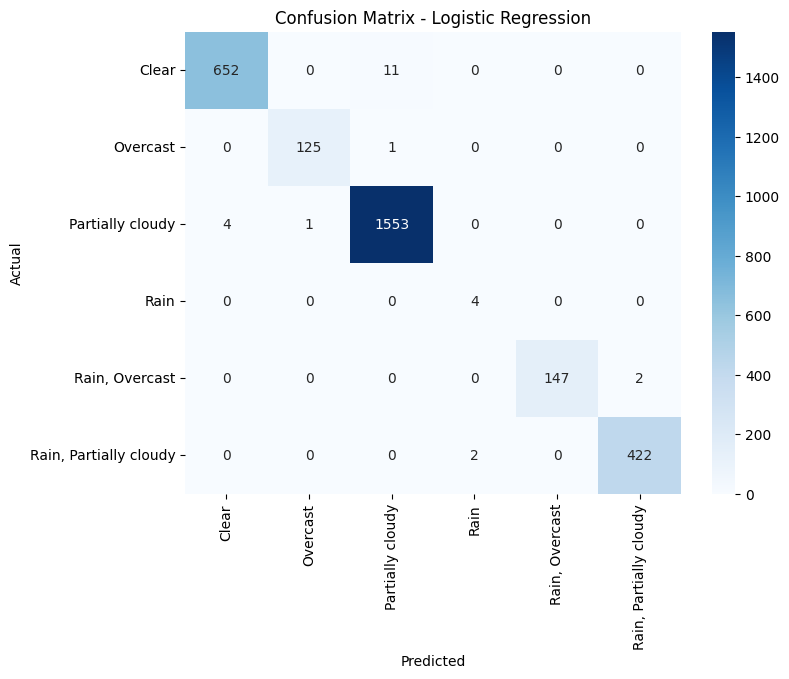

In [72]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [73]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [74]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [75]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9998
Overcast : 0.9986
Partially cloudy : 0.9996
Rain     : 0.9997
Rain, Overcast : 0.9963
Rain, Partially cloudy : 0.9949
Micro-avg : 0.9987


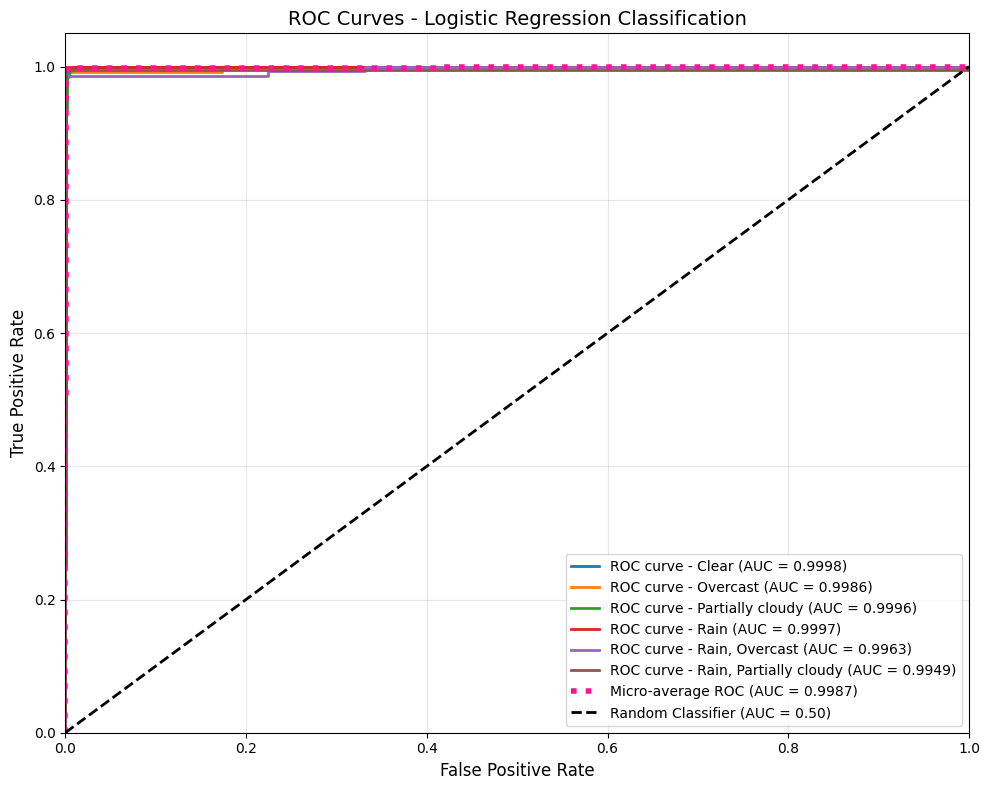

In [76]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [77]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9988
One-vs-One (Weighted)  : 0.9983
Micro-average          : 0.9987


In [78]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.992818, F1: 0.992877, AUC (micro-avg): 0.998669
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [79]:
grid_search = RandomizedSearchCV(
    LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass'), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

,estimator,LGBMClassifie... verbose=0)
,param_distributions,"{'bagging_fraction': [0.8, 0.9, ...], 'bagging_freq': [0, 1, ...], 'feature_fraction': [0.8, 0.9, ...], 'learning_rate': [0.01, 0.05, ...], ...}"
,n_iter,350
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [80]:
%%time
print("Starting Grid Search...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    grid_search.fit(X_train, y_train)

Starting Grid Search...
CPU times: total: 16.4 s
Wall time: 16min 37s


In [81]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'subsample_for_bin': 500000, 'reg_lambda': 0.0, 'reg_alpha': 0.1, 'num_leaves': 150, 'n_estimators': 300, 'min_split_gain': 0.2, 'min_child_weight': 0.001, 'min_child_samples': 50, 'max_depth': 10, 'learning_rate': 0.01, 'feature_fraction': 1.0, 'bagging_freq': 1, 'bagging_fraction': 0.8}
Best Cross-Validation Score: 0.9952406561640637


In [82]:
y_pred_grid = best_grid_model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [83]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [84]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9925
Precision: 0.9925
Recall:    0.9925
F1-Score:  0.9925


In [85]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.98      0.99       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.99      1.00      0.99      1558
                  Rain       1.00      1.00      1.00         4
        Rain, Overcast       1.00      0.99      0.99       149
Rain, Partially cloudy       1.00      1.00      1.00       424

              accuracy                           0.99      2924
             macro avg       1.00      0.99      0.99      2924
          weighted avg       0.99      0.99      0.99      2924



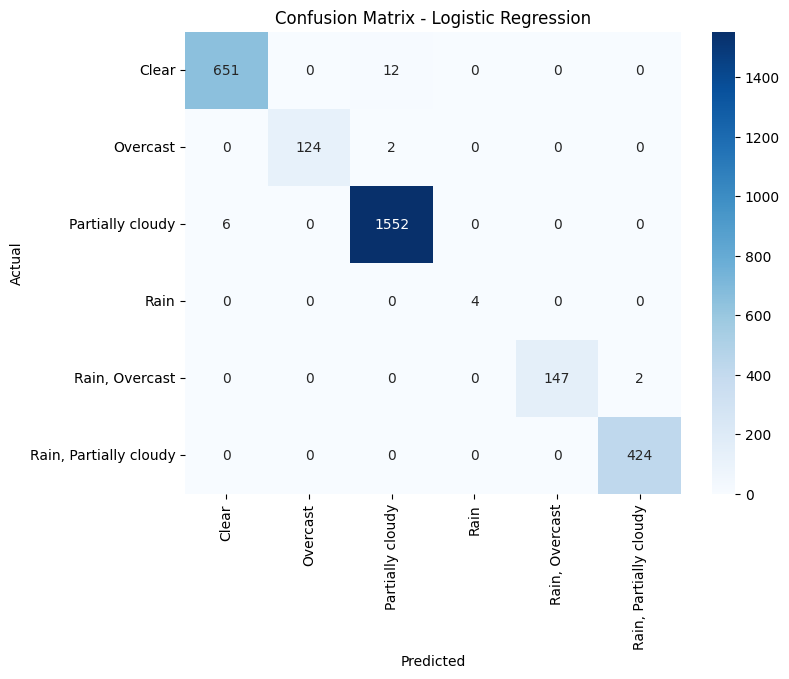

In [86]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [87]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [88]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [89]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9998
Overcast : 0.9971
Partially cloudy : 0.9996
Rain     : 1.0000
Rain, Overcast : 0.9970
Rain, Partially cloudy : 0.9993
Micro-avg : 0.9994


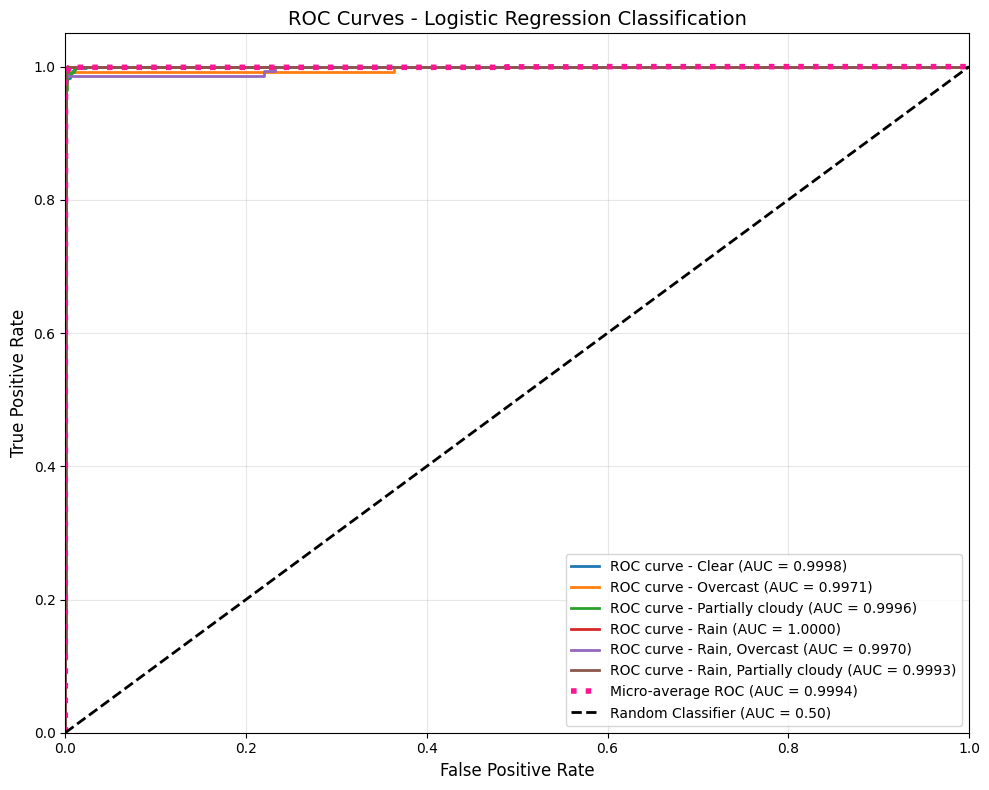

In [90]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [91]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9994
One-vs-One (Weighted)  : 0.9987
Micro-average          : 0.9994


In [92]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.992476, F1: 0.992467, AUC (micro-avg): 0.999356
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [93]:
base_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
base_model

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [94]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

,estimator,LGBMClassifie... verbose=0)
,n_estimators,100
,max_samples,1.0
,max_features,0.8
,bootstrap,True
,bootstrap_features,True
,oob_score,False
,warm_start,False
,n_jobs,-1
,random_state,42
,verbose,1


In [95]:
%%time
print("Starting Bagging Ensemble...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    bagging_clf.fit(X_train, y_train)

Starting Bagging Ensemble...
CPU times: total: 5.66 s
Wall time: 1min 11s


In [96]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.6s remaining:    8.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.1s finished


In [97]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [98]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9938
Precision: 0.9939
Recall:    0.9938
F1-Score:  0.9938


In [99]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.98      0.99       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.99      1.00      0.99      1558
                  Rain       1.00      1.00      1.00         4
        Rain, Overcast       1.00      0.99      0.99       149
Rain, Partially cloudy       1.00      1.00      1.00       424

              accuracy                           0.99      2924
             macro avg       1.00      0.99      0.99      2924
          weighted avg       0.99      0.99      0.99      2924



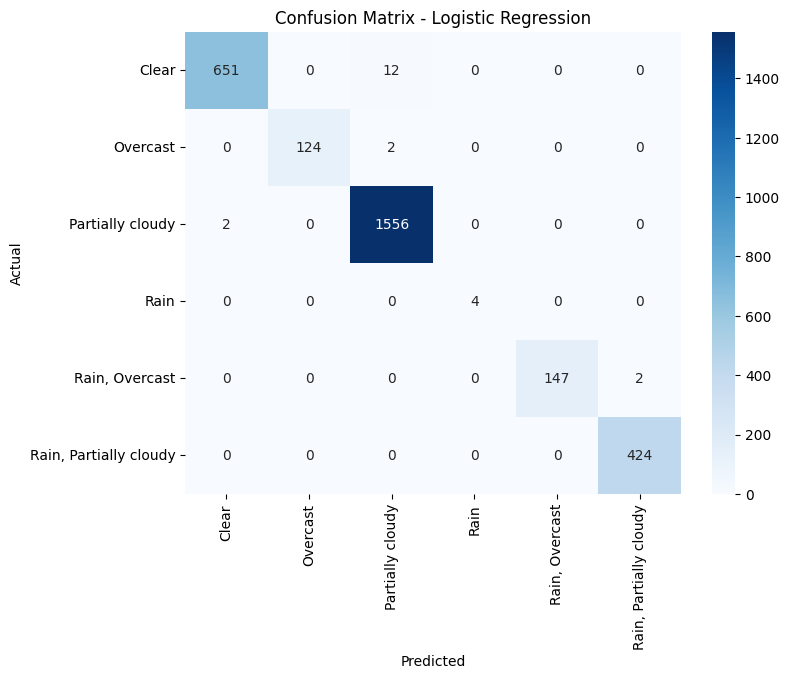

In [100]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [101]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.6s remaining:    8.0s


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.1s finished


In [102]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [103]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9994
Overcast : 1.0000
Partially cloudy : 0.9993
Rain     : 1.0000
Rain, Overcast : 0.9993
Rain, Partially cloudy : 0.9996
Micro-avg : 0.9995


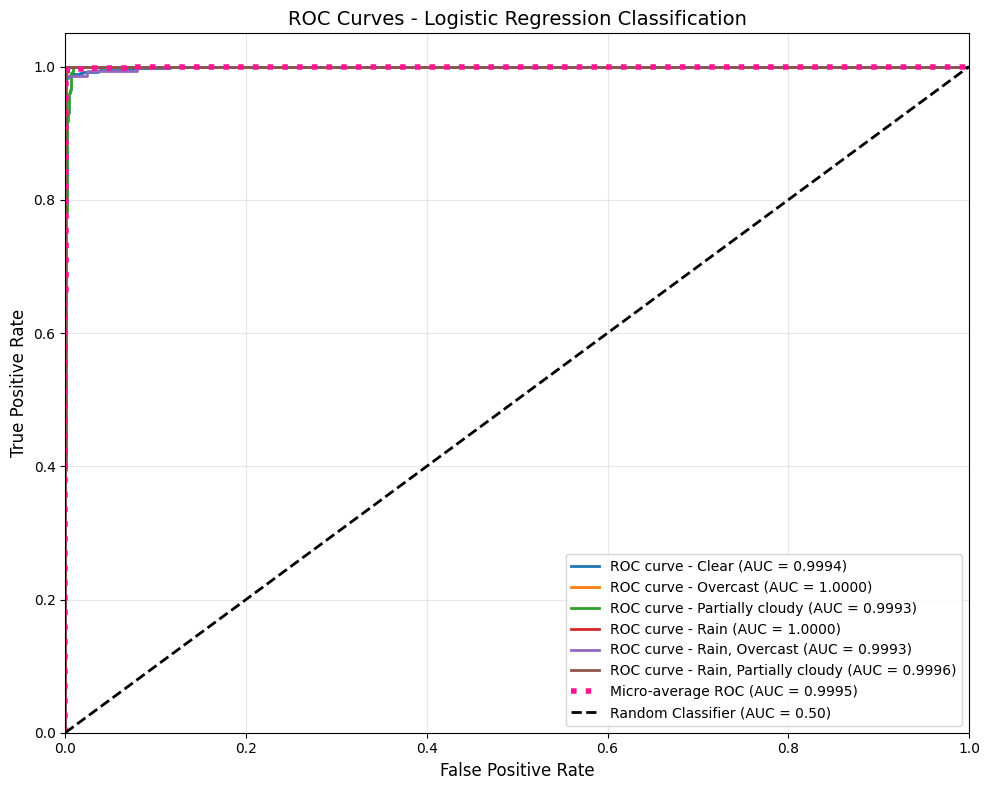

In [104]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [105]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9994
One-vs-One (Weighted)  : 0.9993
Micro-average          : 0.9995


In [106]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.993844, F1: 0.993832, AUC (micro-avg): 0.999535
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


## Robust Scaler

In [107]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Convert back to DataFrame to preserve feature names
X_train = pd.DataFrame(X_train_scaled, columns=X_train_raw.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)

# Clean column names - replace spaces with underscores
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

In [108]:
X_train

,Month,Day,Hour,DaySegments_Afternoon,DaySegments_Early_Morning,DaySegments_Evening,DaySegments_Late_Night,DaySegments_Midday,DaySegments_Morning,DaySegments_Night,...,Humidity,Precip,PrecipProb,Windgust,WindSpeed,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk
0,1.0,-0.066667,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.998300,0.0,0.000000,-0.529046,-0.852941,-0.956781,0.002978,-0.040773,0.655031,0.573643
1,-0.2,-0.666667,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.392181,0.0,0.000000,1.233256,0.800905,0.000931,-0.297841,0.000982,0.000000,22.418605
2,1.4,-0.400000,-1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.509713,0.0,0.000000,0.028780,-0.831448,1.135556,0.520228,-0.253971,0.000000,0.000000
3,-0.2,-0.933333,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.956047,0.0,0.000000,0.305205,-0.013575,0.387419,-0.362373,0.162437,0.193018,0.000000
4,-0.8,0.600000,0.166667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.435406,0.0,0.000000,-0.966779,0.186652,-0.550857,0.995781,0.619781,1.437372,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11687,1.0,0.866667,-0.083333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.758864,0.0,0.000000,-0.516255,0.270362,1.079856,0.553984,-0.822990,1.636550,0.000000
11688,0.8,-0.333333,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.388295,22.0,15.003101,0.074258,-0.288462,0.238512,-0.722760,0.255117,0.199179,7.751938
11689,-0.2,0.666667,-1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.664157,0.0,0.000000,-0.388346,-0.565611,0.838736,0.111194,-0.465695,0.000000,0.000000
11690,-0.4,0.066667,-0.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.523798,0.0,0.000000,-0.450879,0.375566,1.168840,0.506329,0.598657,0.404517,-1.961240


In [109]:
X_test

,Month,Day,Hour,DaySegments_Afternoon,DaySegments_Early_Morning,DaySegments_Evening,DaySegments_Late_Night,DaySegments_Midday,DaySegments_Morning,DaySegments_Night,...,Humidity,Precip,PrecipProb,Windgust,WindSpeed,WindDir,SeaLevelPressure,CloudCover,UVIndex,SevereRisk
0,-0.4,-0.200000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-1.252793,0.0,0.000000,0.542548,-0.098416,0.207154,0.517250,-0.467824,1.848049,0.000000
1,0.8,-0.866667,0.916667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.104177,4.0,3.000000,0.286019,0.278281,0.097678,-0.496401,0.608646,0.000000,0.251938
2,0.2,0.133333,0.416667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.524284,2.0,1.500775,1.314265,0.571267,-0.460320,-1.000745,0.612248,0.422998,18.755814
3,0.2,-0.866667,0.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.239679,58.0,15.003101,1.146562,1.611991,-0.219386,-0.407049,0.582446,0.000000,7.500000
4,-0.2,0.600000,-0.416667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.007042,0.0,0.000000,0.178717,0.201357,0.059737,-0.297841,-0.844113,0.404517,1.437984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2919,0.8,0.200000,-0.583333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.778776,315.0,15.503876,0.746491,0.391403,-0.459886,-0.297841,0.595219,0.000000,-0.089147
2920,0.2,0.600000,-0.083333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.257649,1.0,1.500775,-0.151004,0.408371,0.205291,-0.600645,-0.009497,1.827515,7.751938
2921,-0.2,0.533333,0.583333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.717096,0.0,0.500775,0.268254,0.194570,0.848920,0.105237,0.599476,0.000000,-0.437984
2922,0.8,-0.133333,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.085721,0.0,0.000000,1.431515,0.995475,-0.101776,-0.300819,0.600950,0.000000,0.751938


### Default Parameters

In [110]:
training_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
training_model

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [111]:
%%time
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    training_model.fit(X_train, y_train)

CPU times: total: 3.17 s
Wall time: 1.78 s


In [112]:
y_pred = training_model.predict(X_test)
y_pred

array(['Clear', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype=object)

In [113]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [114]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [115]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9935
Precision: 0.9937
Recall:    0.9935
F1-Score:  0.9936


In [116]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.99      0.99       663
              Overcast       0.99      0.99      0.99       126
      Partially cloudy       0.99      1.00      1.00      1558
                  Rain       0.67      1.00      0.80         4
        Rain, Overcast       1.00      0.99      0.99       149
Rain, Partially cloudy       1.00      1.00      1.00       424

              accuracy                           0.99      2924
             macro avg       0.94      0.99      0.96      2924
          weighted avg       0.99      0.99      0.99      2924



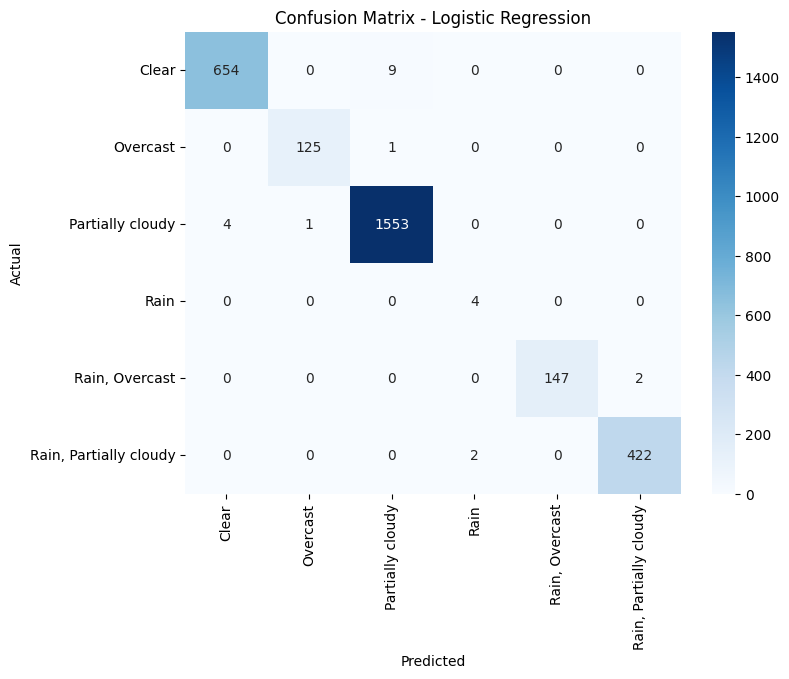

In [117]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [118]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [119]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [120]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9999
Overcast : 0.9987
Partially cloudy : 0.9997
Rain     : 0.9995
Rain, Overcast : 0.9964
Rain, Partially cloudy : 0.9946
Micro-avg : 0.9987


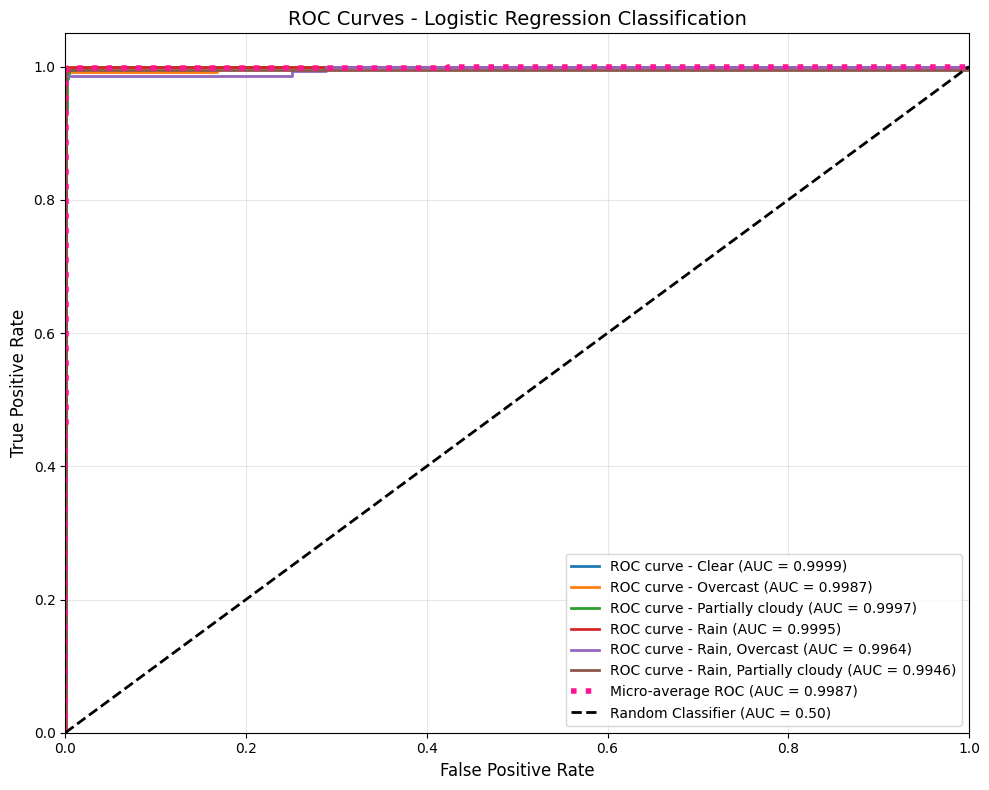

In [121]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [122]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9988
One-vs-One (Weighted)  : 0.9983
Micro-average          : 0.9987


In [123]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.993502, F1: 0.993564, AUC (micro-avg): 0.998673
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Tuning with Grid Search

In [124]:
grid_search = RandomizedSearchCV(
    LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass'), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

,estimator,LGBMClassifie... verbose=0)
,param_distributions,"{'bagging_fraction': [0.8, 0.9, ...], 'bagging_freq': [0, 1, ...], 'feature_fraction': [0.8, 0.9, ...], 'learning_rate': [0.01, 0.05, ...], ...}"
,n_iter,350
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [125]:
%%time
print("Starting Grid Search...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    grid_search.fit(X_train, y_train)

Starting Grid Search...
CPU times: total: 11.6 s
Wall time: 16min 36s


In [126]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'subsample_for_bin': 200000, 'reg_lambda': 0.5, 'reg_alpha': 0.5, 'num_leaves': 31, 'n_estimators': 200, 'min_split_gain': 0.1, 'min_child_weight': 0.01, 'min_child_samples': 200, 'max_depth': -1, 'learning_rate': 0.2, 'feature_fraction': 1.0, 'bagging_freq': 0, 'bagging_fraction': 0.9}
Best Cross-Validation Score: 0.9954131992909515


In [127]:
y_pred_grid = best_grid_model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [128]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [129]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9942
Precision: 0.9942
Recall:    0.9942
F1-Score:  0.9942


In [130]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.99      0.99       663
              Overcast       0.99      0.99      0.99       126
      Partially cloudy       0.99      1.00      1.00      1558
                  Rain       1.00      1.00      1.00         4
        Rain, Overcast       1.00      0.99      0.99       149
Rain, Partially cloudy       1.00      1.00      1.00       424

              accuracy                           0.99      2924
             macro avg       1.00      0.99      0.99      2924
          weighted avg       0.99      0.99      0.99      2924



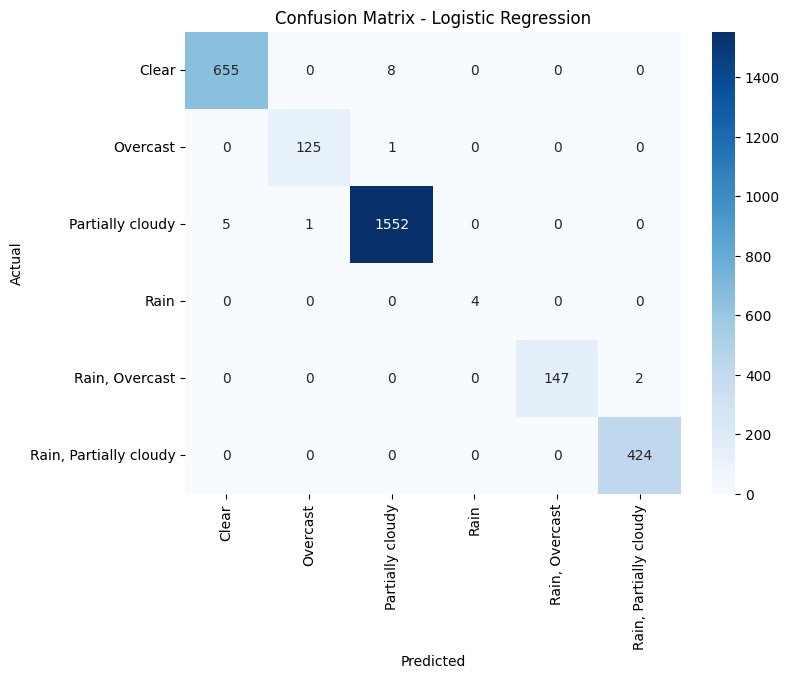

In [131]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [132]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [133]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [134]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9998
Overcast : 0.9998
Partially cloudy : 0.9998
Rain     : 1.0000
Rain, Overcast : 0.9968
Rain, Partially cloudy : 0.9996
Micro-avg : 0.9997


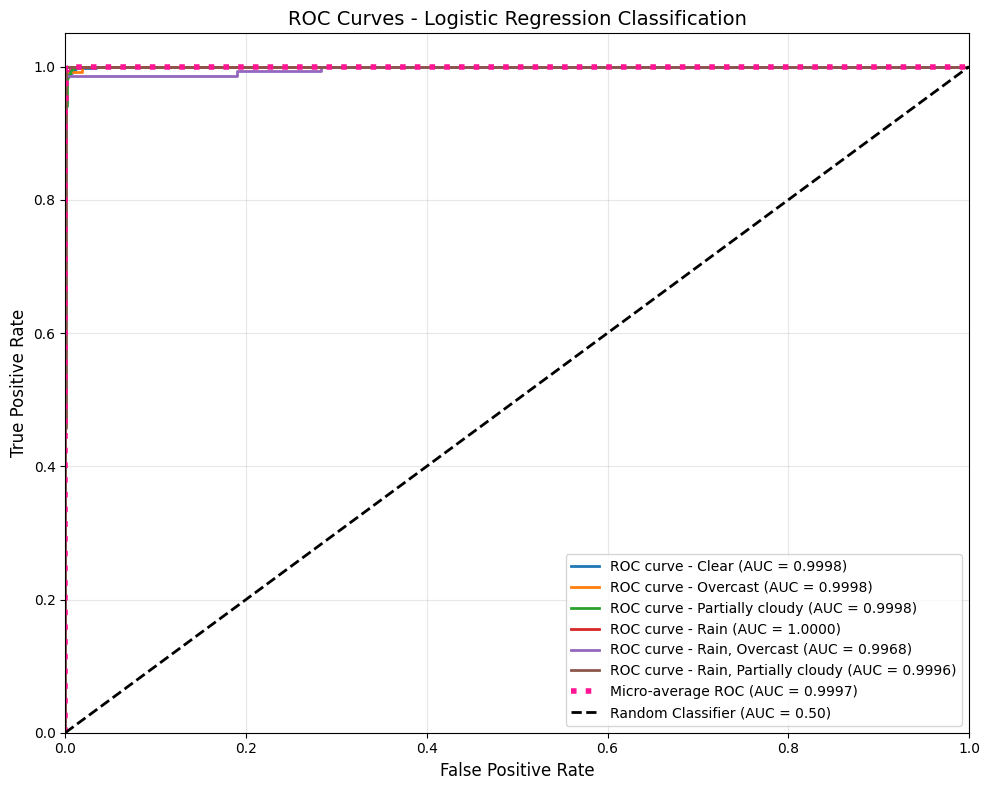

In [135]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [136]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9996
One-vs-One (Weighted)  : 0.9993
Micro-average          : 0.9997


In [137]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.994186, F1: 0.994182, AUC (micro-avg): 0.999680
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


### Ensambling with Bagging

In [138]:
base_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
base_model

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [139]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

,estimator,LGBMClassifie... verbose=0)
,n_estimators,100
,max_samples,1.0
,max_features,0.8
,bootstrap,True
,bootstrap_features,True
,oob_score,False
,warm_start,False
,n_jobs,-1
,random_state,42
,verbose,1


In [140]:
%%time
print("Starting Bagging Ensemble...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    bagging_clf.fit(X_train, y_train)

Starting Bagging Ensemble...
CPU times: total: 4.98 s
Wall time: 1min 10s


In [141]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.6s remaining:    8.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.6s finished


In [142]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [143]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9942
Precision: 0.9943
Recall:    0.9942
F1-Score:  0.9942


In [144]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.98      0.99       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.99      1.00      1.00      1558
                  Rain       0.80      1.00      0.89         4
        Rain, Overcast       1.00      0.99      0.99       149
Rain, Partially cloudy       1.00      1.00      1.00       424

              accuracy                           0.99      2924
             macro avg       0.96      0.99      0.98      2924
          weighted avg       0.99      0.99      0.99      2924



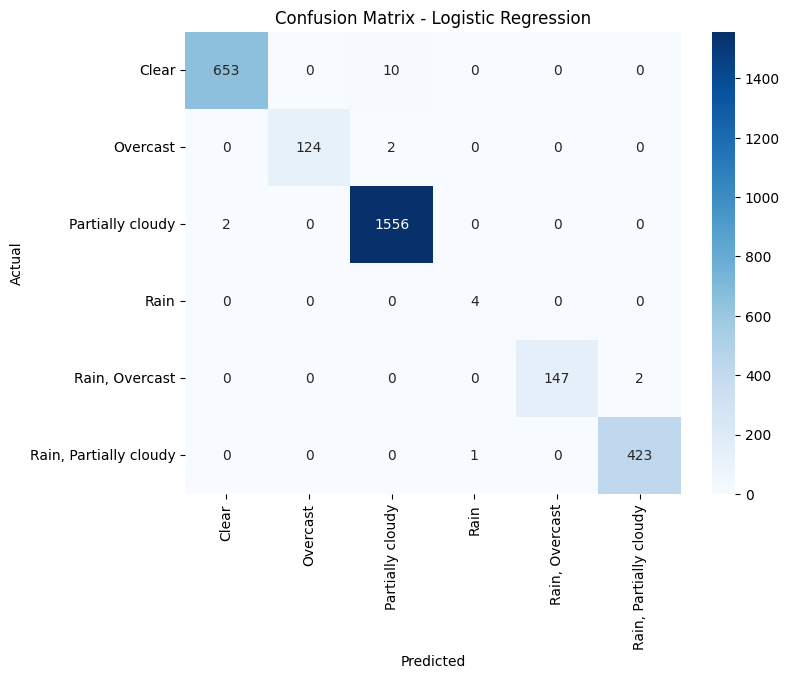

In [145]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [146]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.4s remaining:    7.3s


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.5s finished


In [147]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [148]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9996
Overcast : 1.0000
Partially cloudy : 0.9995
Rain     : 1.0000
Rain, Overcast : 0.9993
Rain, Partially cloudy : 0.9996
Micro-avg : 0.9996


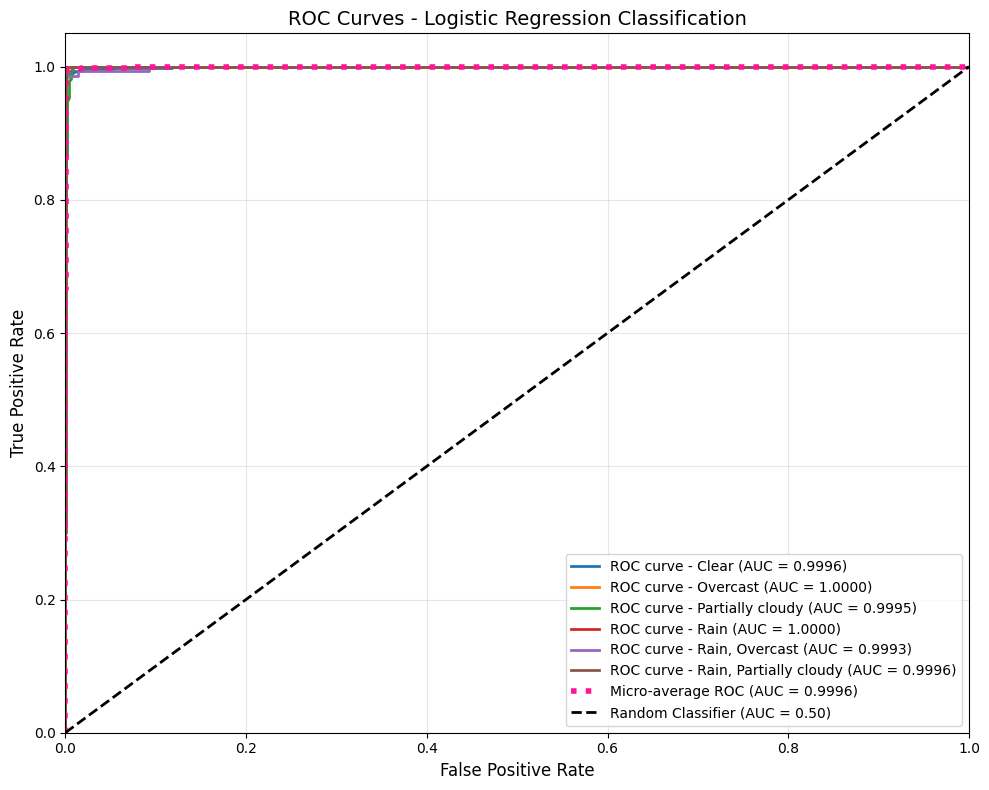

In [149]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [150]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9996
One-vs-One (Weighted)  : 0.9995
Micro-average          : 0.9996


In [151]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

✨ New classification model added:
   Accuracy: 0.994186, F1: 0.994196, AUC (micro-avg): 0.999601
   Features: 27
💾 Registry updated: Model_Training_History/History_Classification.csv


# Selected Features

In [152]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14616 entries, 0 to 14615
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   DateTime                   14616 non-null  datetime64[ns]
 1   Year                       14616 non-null  int64         
 2   Month                      14616 non-null  int64         
 3   Day                        14616 non-null  int64         
 4   Hour                       14616 non-null  int64         
 5   DaySegments                14616 non-null  object        
 6   DaySegments_Afternoon      14616 non-null  int64         
 7   DaySegments_Early Morning  14616 non-null  int64         
 8   DaySegments_Evening        14616 non-null  int64         
 9   DaySegments_Late Night     14616 non-null  int64         
 10  DaySegments_Midday         14616 non-null  int64         
 11  DaySegments_Morning        14616 non-null  int64         
 12  DayS

## Run Again

In [153]:
X_train_raw = weather_data_train.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_train = weather_data_train['Conditions']

In [154]:
X_test_raw = weather_data_test.drop(columns=['DateTime', # Model cannot use DateTime as a feature
                                                'Year', # No Effect on weather data
                                                'Season', # Season is categorical, not numerical
                                                'DaySegments', # DaySegments is categorical, not numerical
                                                'Visibility',  # Target variable
                                                'SolarRadiation', # Target variable
                                                'SolarEnergy', # Target variable
                                                'Conditions', # Target variable
                                                'Icon', # Target variable
                                                
                                                'Day', # Same day from different months act differently
                                                'Windgust', # I think their effect is negligible
                                                'WindSpeed', # I think their effect is negligible
                                                'WindDir']) # I think their effect is negligible
                                                        # All others features are important for the model
y_test = weather_data_test['Conditions']

In [155]:
feature_columns = [col for col in X_train_raw.columns]
feature_columns_for_saving = ','.join(feature_columns)

In [156]:
print("X_train: ", len(X_train_raw))
print("y_train: ", len(y_train))
print("\nX_test: ", len(X_test_raw))
print("y_test: ", len(y_test))

X_train:  11692
y_train:  11692

X_test:  2924
y_test:  2924


### MinMax Scaler

In [157]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Convert back to DataFrame to preserve feature names
X_train = pd.DataFrame(X_train_scaled, columns=X_train_raw.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)

# Clean column names - replace spaces with underscores
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

In [158]:
X_train

,Month,Hour,DaySegments_Afternoon,DaySegments_Early_Morning,DaySegments_Evening,DaySegments_Late_Night,DaySegments_Midday,DaySegments_Morning,DaySegments_Night,Season_Autumn,...,Temp,FeelsLike,Dew,Humidity,Precip,PrecipProb,SeaLevelPressure,CloudCover,UVIndex,SevereRisk
0,0.818182,0.695652,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.710705,0.592694,0.685996,0.430377,0.000000,0.0000,0.645308,0.4906,0.319,0.089508
1,0.272727,0.869565,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.679878,0.630964,0.776331,0.579161,0.000000,0.0000,0.568870,0.5161,0.000,0.684399
2,1.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.309959,0.228131,0.535306,0.800548,0.000000,0.0000,0.776741,0.3604,0.000,0.073886
3,0.272727,0.782609,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.605691,0.469433,0.580276,0.440749,0.000000,0.0000,0.552472,0.6147,0.094,0.073886
4,0.000000,0.608696,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.405149,0.297962,0.477712,0.568550,0.000000,0.0000,0.897578,0.8940,0.700,0.073886
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11687,0.818182,0.478261,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.659553,0.551193,0.689546,0.489151,0.000000,0.0000,0.785318,0.0129,0.797,0.073886
11688,0.727273,0.782609,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.621274,0.615308,0.870611,0.770744,0.004944,0.9677,0.460898,0.6713,0.097,0.284991
11689,0.272727,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.591125,0.476889,0.631164,0.512399,0.000000,0.0000,0.672805,0.2311,0.000,0.073886
11690,0.181818,0.347826,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.471883,0.346918,0.725444,0.804006,0.000000,0.0000,0.773209,0.8811,0.197,0.020477


In [159]:
X_test

,Month,Hour,DaySegments_Afternoon,DaySegments_Early_Morning,DaySegments_Evening,DaySegments_Late_Night,DaySegments_Midday,DaySegments_Morning,DaySegments_Night,Season_Autumn,...,Temp,FeelsLike,Dew,Humidity,Precip,PrecipProb,SeaLevelPressure,CloudCover,UVIndex,SevereRisk
0,0.181818,0.521739,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.691057,0.540755,0.588166,0.367907,0.000000,0.0000,0.775984,0.2298,0.900,0.073886
1,0.727273,1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.643631,0.600149,0.809073,0.649857,0.000899,0.1935,0.518416,0.8872,0.000,0.080747
2,0.454545,0.739130,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.648713,0.698310,0.926233,0.804125,0.000449,0.0968,0.390262,0.8894,0.206,0.584653
3,0.454545,0.869565,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.583333,0.523857,0.800394,0.734263,0.013034,0.9677,0.541120,0.8712,0.000,0.278130
4,0.272727,0.304348,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.640921,0.619284,0.817357,0.677158,0.000000,0.0000,0.568870,0.0000,0.197,0.113046
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2919,0.727273,0.217391,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.545393,0.489811,0.849310,0.866595,0.070787,1.0000,0.568870,0.8790,0.000,0.071459
2920,0.454545,0.478261,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.743564,0.773857,0.889152,0.612184,0.000225,0.0968,0.491927,0.5097,0.890,0.284991
2921,0.272727,0.826087,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.676829,0.582505,0.714793,0.499404,0.000000,0.0323,0.671292,0.8816,0.000,0.061959
2922,0.727273,0.869565,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.610772,0.563618,0.807890,0.696471,0.000000,0.0000,0.568113,0.8825,0.000,0.094364


#### Default Parameters

In [160]:
training_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
training_model

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [161]:
%%time
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    training_model.fit(X_train, y_train)

CPU times: total: 3.12 s
Wall time: 1.55 s


In [162]:
y_pred = training_model.predict(X_test)
y_pred

array(['Partially cloudy', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype=object)

In [163]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [164]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [165]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9918
Precision: 0.9920
Recall:    0.9918
F1-Score:  0.9918


In [166]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.98      0.99       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.99      1.00      0.99      1558
                  Rain       0.67      1.00      0.80         4
        Rain, Overcast       0.99      0.99      0.99       149
Rain, Partially cloudy       1.00      0.99      0.99       424

              accuracy                           0.99      2924
             macro avg       0.94      0.99      0.96      2924
          weighted avg       0.99      0.99      0.99      2924



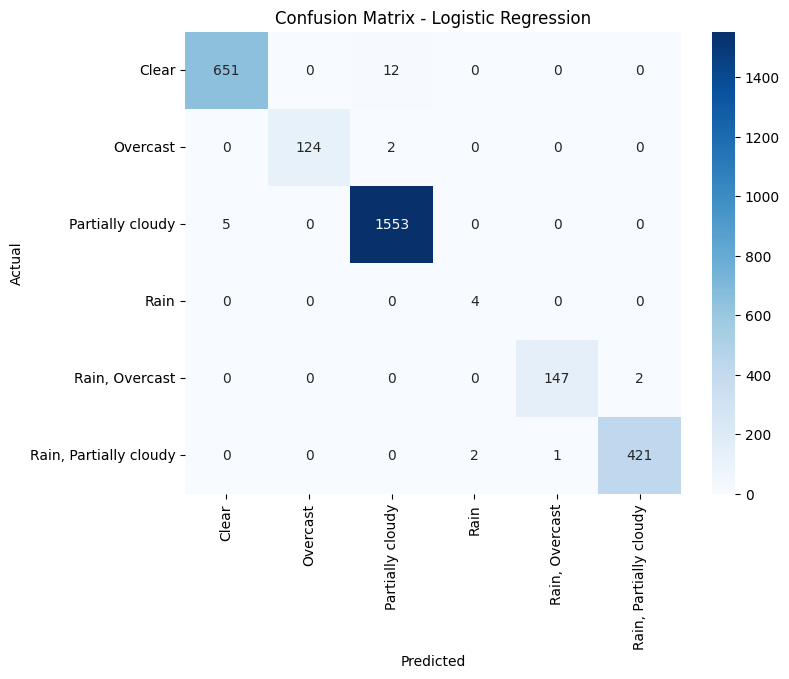

In [167]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [168]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [169]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [170]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9998
Overcast : 0.9979
Partially cloudy : 0.9995
Rain     : 0.9997
Rain, Overcast : 0.9935
Rain, Partially cloudy : 0.9948
Micro-avg : 0.9985


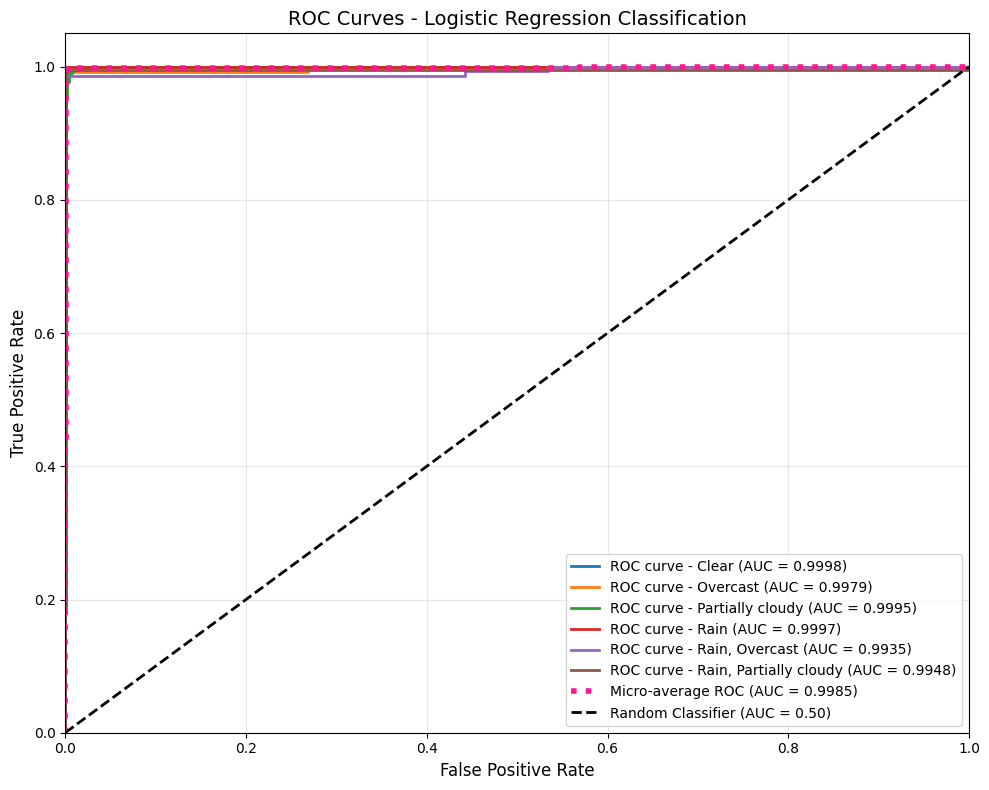

In [171]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [172]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9985
One-vs-One (Weighted)  : 0.9979
Micro-average          : 0.9985


In [173]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.992476 ≈ 0.991792 (similar)
   F1-Score: 0.992525 ≈ 0.991849 (similar)
   AUC (micro-avg): 0.998495 ≈ 0.998502
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [174]:
grid_search = RandomizedSearchCV(
    LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass'), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

,estimator,LGBMClassifie... verbose=0)
,param_distributions,"{'bagging_fraction': [0.8, 0.9, ...], 'bagging_freq': [0, 1, ...], 'feature_fraction': [0.8, 0.9, ...], 'learning_rate': [0.01, 0.05, ...], ...}"
,n_iter,350
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [175]:
%%time
print("Starting Grid Search...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    grid_search.fit(X_train, y_train)

Starting Grid Search...
CPU times: total: 10 s
Wall time: 14min 59s


In [176]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'subsample_for_bin': 500000, 'reg_lambda': 0.1, 'reg_alpha': 0.0, 'num_leaves': 31, 'n_estimators': 100, 'min_split_gain': 0.2, 'min_child_weight': 0.01, 'min_child_samples': 100, 'max_depth': 7, 'learning_rate': 0.2, 'feature_fraction': 1.0, 'bagging_freq': 5, 'bagging_fraction': 0.9}
Best Cross-Validation Score: 0.9954263695556304


In [177]:
y_pred_grid = best_grid_model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


In [178]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [179]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9925
Precision: 0.9926
Recall:    0.9925
F1-Score:  0.9925


In [180]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.98      0.99       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.99      1.00      0.99      1558
                  Rain       0.80      1.00      0.89         4
        Rain, Overcast       0.99      0.99      0.99       149
Rain, Partially cloudy       1.00      1.00      1.00       424

              accuracy                           0.99      2924
             macro avg       0.96      0.99      0.97      2924
          weighted avg       0.99      0.99      0.99      2924



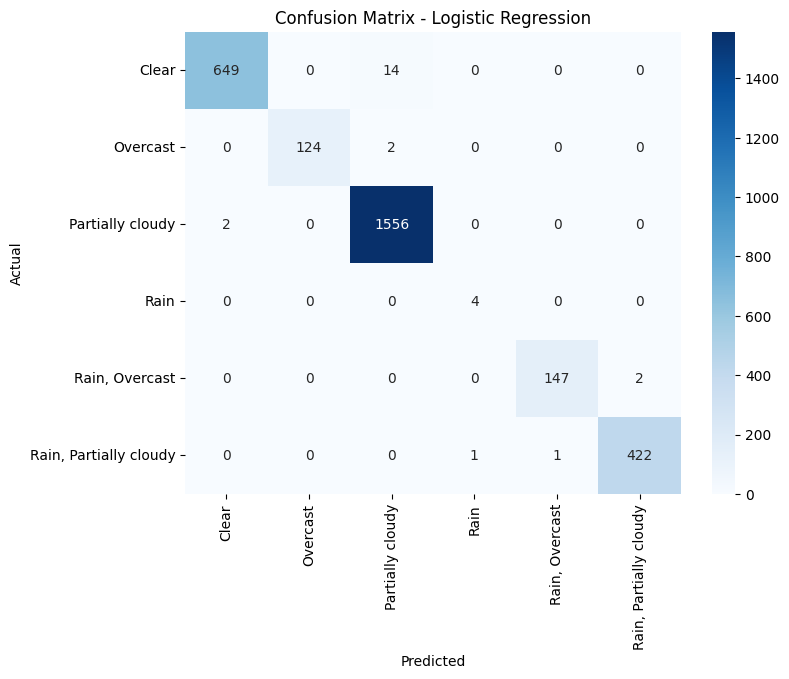

In [181]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [182]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [183]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [184]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9998
Overcast : 0.9991
Partially cloudy : 0.9996
Rain     : 0.9997
Rain, Overcast : 0.9980
Rain, Partially cloudy : 0.9992
Micro-avg : 0.9996


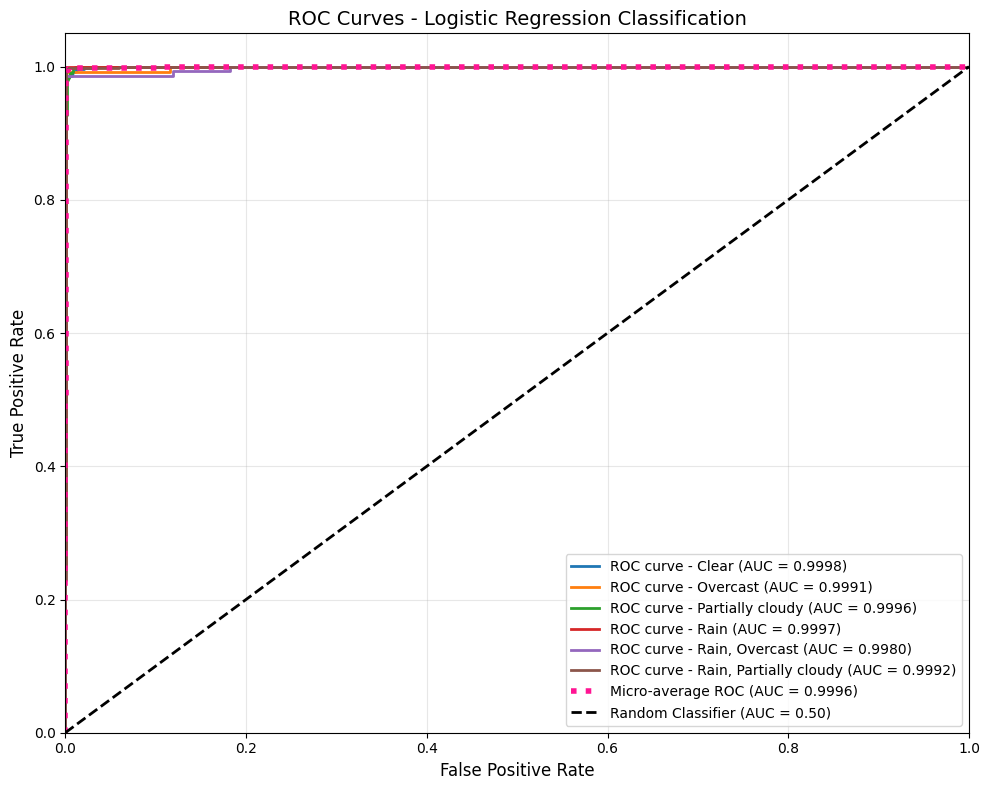

In [185]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [186]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9995
One-vs-One (Weighted)  : 0.9991
Micro-average          : 0.9996


In [187]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.993160 ≈ 0.992476 (similar)
   F1-Score: 0.993147 ≈ 0.992479 (similar)
   AUC (micro-avg): 0.999567 ≈ 0.999601
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [188]:
base_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
base_model

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [189]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

,estimator,LGBMClassifie... verbose=0)
,n_estimators,100
,max_samples,1.0
,max_features,0.8
,bootstrap,True
,bootstrap_features,True
,oob_score,False
,warm_start,False
,n_jobs,-1
,random_state,42
,verbose,1


In [190]:
%%time
print("Starting Bagging Ensemble...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    bagging_clf.fit(X_train, y_train)

Starting Bagging Ensemble...
CPU times: total: 4.83 s
Wall time: 1min 3s


In [191]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.7s remaining:    8.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.1s finished


In [192]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [193]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9651
Precision: 0.9654
Recall:    0.9651
F1-Score:  0.9623


In [194]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.97      0.98       663
              Overcast       1.00      0.60      0.75       126
      Partially cloudy       0.96      1.00      0.98      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       1.00      0.85      0.92       149
Rain, Partially cloudy       0.94      1.00      0.97       424

              accuracy                           0.97      2924
             macro avg       0.82      0.73      0.76      2924
          weighted avg       0.97      0.97      0.96      2924



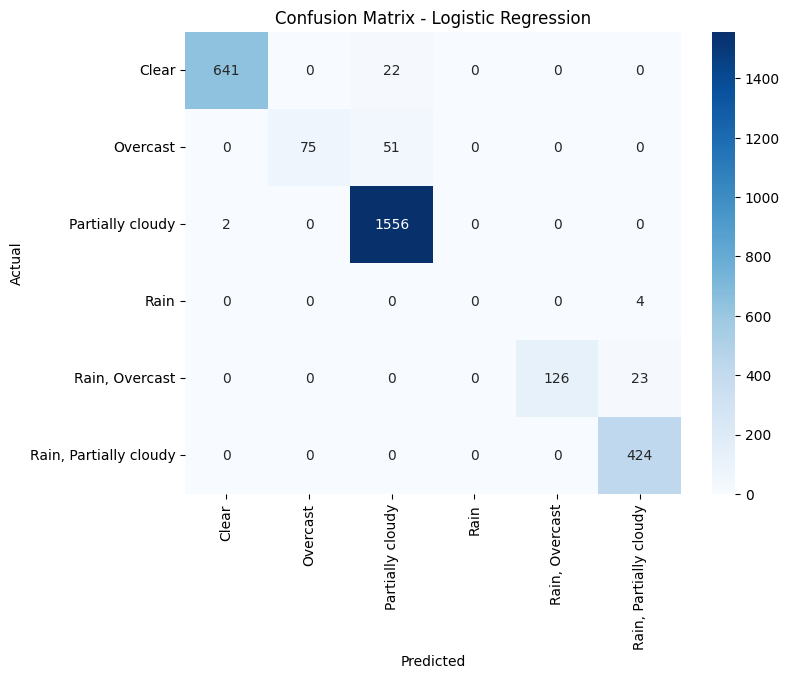

In [195]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [196]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.4s remaining:    7.5s


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.6s finished


In [197]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [198]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9987
Overcast : 0.9999
Partially cloudy : 0.9990
Rain     : 1.0000
Rain, Overcast : 0.9994
Rain, Partially cloudy : 0.9997
Micro-avg : 0.9989


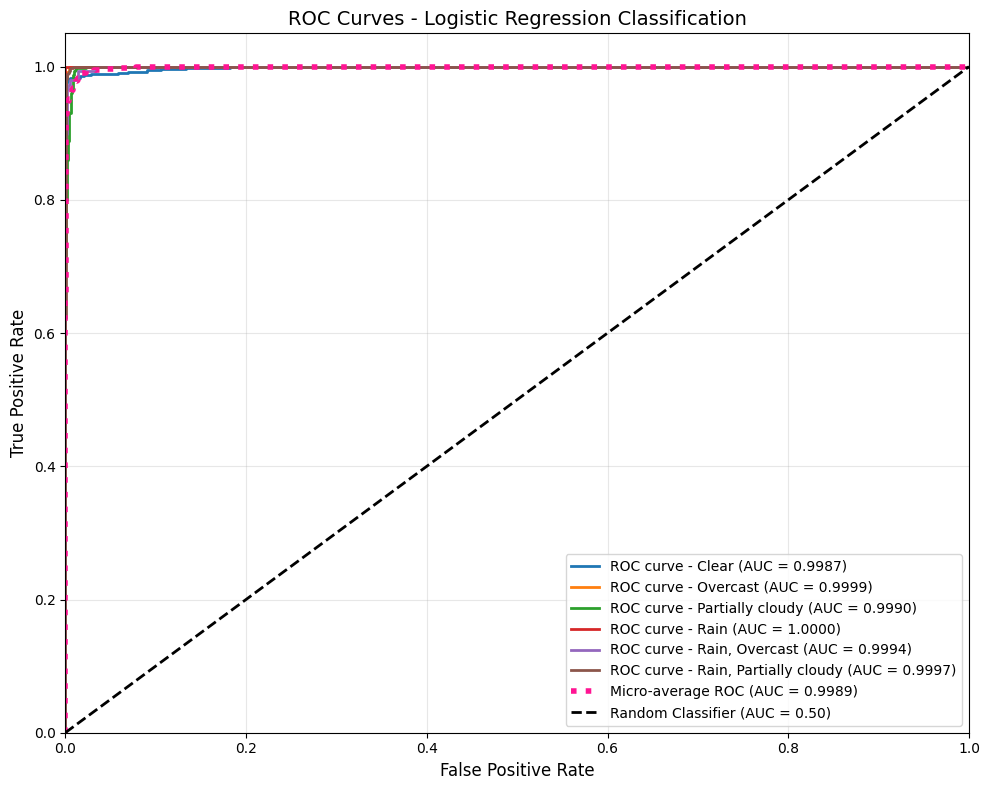

In [199]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [200]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9991
One-vs-One (Weighted)  : 0.9993
Micro-average          : 0.9989


In [201]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "MinMaxScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

❌ Classification model not improved:
   Current Accuracy: 0.965116, Best Accuracy: 0.992476
   Current F1: 0.962256, Best F1: 0.992454
   Current AUC (micro-avg): 0.998906, Best AUC: 0.999328
   Current Features: 23, Best Features: 27


### Standard Scaler

In [202]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Convert back to DataFrame to preserve feature names
X_train = pd.DataFrame(X_train_scaled, columns=X_train_raw.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)

# Clean column names - replace spaces with underscores
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

In [203]:
X_train

,Month,Hour,DaySegments_Afternoon,DaySegments_Early_Morning,DaySegments_Evening,DaySegments_Late_Night,DaySegments_Midday,DaySegments_Morning,DaySegments_Night,Season_Autumn,...,Temp,FeelsLike,Dew,Humidity,Precip,PrecipProb,SeaLevelPressure,CloudCover,UVIndex,SevereRisk
0,1.344591,0.644438,2.544740,-0.249272,-0.330921,-0.574453,-0.36552,-0.560228,-0.341010,2.404559,...,0.980742,0.618463,0.034605,-1.224754,-0.193864,-0.520253,-0.047466,-0.128120,0.288613,-0.335042
1,-0.532501,1.223925,-0.392967,-0.249272,-0.330921,-0.574453,-0.36552,-0.560228,2.932464,-0.415877,...,0.796327,0.824971,0.508797,-0.385991,-0.193864,-0.520253,-0.552107,-0.055637,-0.741700,3.447634
2,1.970288,-1.673508,-0.392967,-0.249272,-0.330921,1.740786,-0.36552,-0.560228,-0.341010,-0.415877,...,-1.416648,-1.348721,-0.756404,0.862072,-0.193864,-0.520253,0.820252,-0.498209,-0.741700,-0.434374
3,-0.532501,0.934182,-0.392967,-0.249272,3.021873,-0.574453,-0.36552,-0.560228,-0.341010,-0.415877,...,0.352516,-0.046652,-0.520344,-1.166282,-0.193864,-0.520253,-0.660364,0.224631,-0.438097,-0.434374
4,-1.471047,0.354695,2.544740,-0.249272,-0.330921,-0.574453,-0.36552,-0.560228,-0.341010,-0.415877,...,-0.847192,-0.971912,-1.058727,-0.445806,-0.193864,-0.520253,1.618019,1.018532,1.519174,-0.434374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11687,1.344591,-0.079920,-0.392967,-0.249272,-0.330921,-0.574453,-0.36552,1.784987,-0.341010,2.404559,...,0.674735,0.394523,0.053242,-0.893415,-0.193864,-0.520253,0.876878,-1.485966,1.832467,-0.434374
11688,1.031742,0.934182,-0.392967,-0.249272,3.021873,-0.574453,-0.36552,-0.560228,-0.341010,2.404559,...,0.445737,0.740490,1.003695,0.694051,0.068351,2.070112,-1.264935,0.385514,-0.428407,0.907952
11689,-0.532501,-1.673508,-0.392967,-0.249272,-0.330921,1.740786,-0.36552,-0.560228,-0.341010,-0.415877,...,0.265375,-0.006423,-0.253223,-0.762359,-0.193864,-0.520253,0.134072,-0.865740,-0.741700,-0.434374
11690,-0.845349,-0.514535,-0.392967,-0.249272,-0.330921,-0.574453,-0.36552,1.784987,-0.341010,-0.415877,...,-0.447965,-0.707743,0.241676,0.881563,-0.193864,-0.520253,0.796935,0.981864,-0.105425,-0.773983


In [204]:
X_test

,Month,Hour,DaySegments_Afternoon,DaySegments_Early_Morning,DaySegments_Evening,DaySegments_Late_Night,DaySegments_Midday,DaySegments_Morning,DaySegments_Night,Season_Autumn,...,Temp,FeelsLike,Dew,Humidity,Precip,PrecipProb,SeaLevelPressure,CloudCover,UVIndex,SevereRisk
0,-0.845349,0.064952,-0.392967,-0.249272,-0.330921,-0.574453,2.735829,-0.560228,-0.341010,-0.415877,...,0.863203,0.338203,-0.478930,-1.576926,-0.193864,-0.520253,0.815255,-0.869435,2.165139,-0.434374
1,1.031742,1.658540,-0.392967,-0.249272,-0.330921,1.740786,-0.365520,-0.560228,-0.341010,2.404559,...,0.579488,0.658692,0.680665,0.012556,-0.146189,-0.002287,-0.885204,0.999203,-0.741700,-0.390749
2,0.093196,0.789310,2.544740,-0.249272,-0.330921,-0.574453,-0.365520,-0.560228,-0.341010,-0.415877,...,0.609886,1.188370,1.295665,0.882235,-0.170027,-0.261136,-1.731270,1.005456,-0.076357,2.813385
3,0.093196,1.223925,-0.392967,-0.249272,3.021873,-0.574453,-0.365520,-0.560228,-0.341010,-0.415877,...,0.218765,0.247018,0.635110,0.488393,0.497431,2.070112,-0.735311,0.953724,-0.741700,0.864327
4,-0.532501,-0.659406,-0.392967,-0.249272,-0.330921,-0.574453,-0.365520,1.784987,-0.341010,-0.415877,...,0.563276,0.761946,0.724150,0.166464,-0.193864,-0.520253,-0.552107,-1.522634,-0.105425,-0.185373
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2919,1.031742,-0.949150,-0.392967,4.011679,-0.330921,-0.574453,-0.365520,-0.560228,-0.341010,2.404559,...,-0.008207,0.063307,0.891877,1.234408,3.560586,2.156573,-0.552107,0.975895,-0.741700,-0.449811
2920,0.093196,-0.079920,-0.392967,-0.249272,-0.330921,-0.574453,-0.365520,1.784987,-0.341010,-0.415877,...,1.177316,1.596021,1.101018,-0.199823,-0.181946,-0.261136,-1.060080,-0.073828,2.132840,0.907952
2921,-0.532501,1.079053,-0.392967,-0.249272,3.021873,-0.574453,-0.365520,-0.560228,-0.341010,-0.415877,...,0.778088,0.563484,0.185767,-0.835616,-0.193864,-0.433792,0.124079,0.983285,-0.741700,-0.510216
2922,1.031742,1.223925,-0.392967,-0.249272,-0.330921,-0.574453,-0.365520,-0.560228,2.932464,2.404559,...,0.382914,0.461571,0.674453,0.275341,-0.193864,-0.520253,-0.557104,0.985843,-0.741700,-0.304169


#### Default Parameters

In [205]:
training_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
training_model

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [206]:
%%time
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    training_model.fit(X_train, y_train)

CPU times: total: 3.12 s
Wall time: 1.75 s


In [207]:
y_pred = training_model.predict(X_test)
y_pred

array(['Clear', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype=object)

In [208]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [209]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [210]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9942
Precision: 0.9944
Recall:    0.9942
F1-Score:  0.9942


In [211]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.99      0.99       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.99      1.00      1.00      1558
                  Rain       0.67      1.00      0.80         4
        Rain, Overcast       1.00      0.99      0.99       149
Rain, Partially cloudy       1.00      1.00      1.00       424

              accuracy                           0.99      2924
             macro avg       0.94      0.99      0.96      2924
          weighted avg       0.99      0.99      0.99      2924



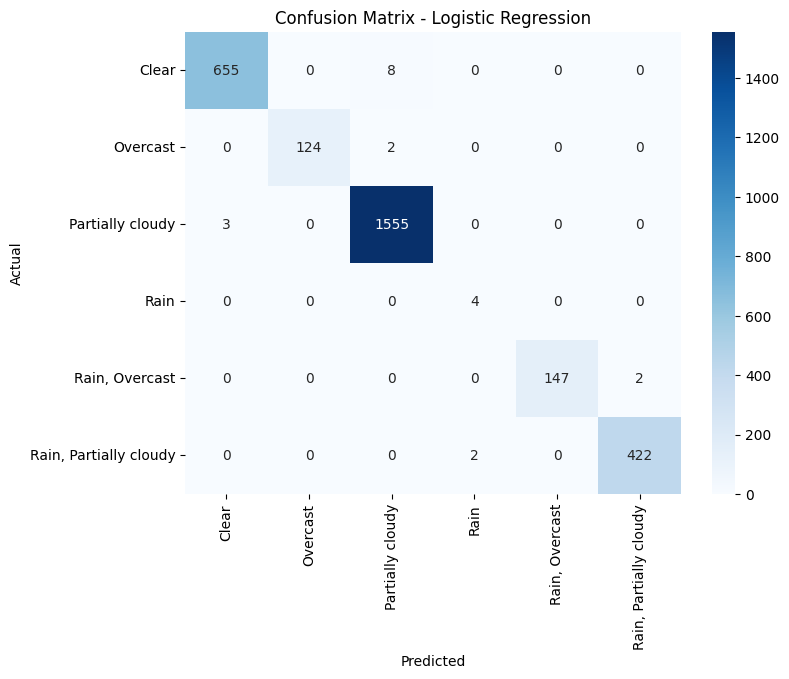

In [212]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [213]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [214]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [215]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9999
Overcast : 0.9982
Partially cloudy : 0.9995
Rain     : 0.9995
Rain, Overcast : 0.9944
Rain, Partially cloudy : 0.9946
Micro-avg : 0.9985


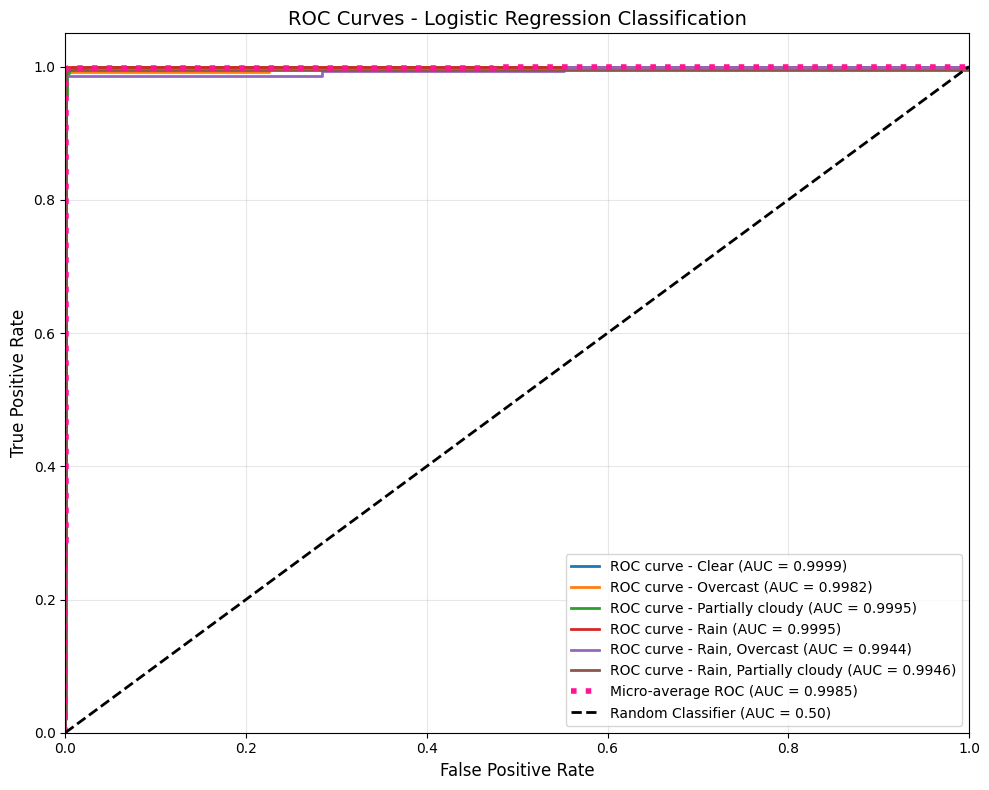

In [216]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [217]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9985
One-vs-One (Weighted)  : 0.9979
Micro-average          : 0.9985


In [218]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.992818 → 0.994186
   F1-Score: 0.992877 → 0.994247
   AUC (micro-avg): 0.998669 → 0.998533
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [219]:
grid_search = RandomizedSearchCV(
    LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass'), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

,estimator,LGBMClassifie... verbose=0)
,param_distributions,"{'bagging_fraction': [0.8, 0.9, ...], 'bagging_freq': [0, 1, ...], 'feature_fraction': [0.8, 0.9, ...], 'learning_rate': [0.01, 0.05, ...], ...}"
,n_iter,350
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [220]:
%%time
print("Starting Grid Search...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    grid_search.fit(X_train, y_train)

Starting Grid Search...
CPU times: total: 11.2 s
Wall time: 14min 53s


In [221]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'subsample_for_bin': 200000, 'reg_lambda': 1.0, 'reg_alpha': 1.0, 'num_leaves': 50, 'n_estimators': 300, 'min_split_gain': 0.1, 'min_child_weight': 0.01, 'min_child_samples': 100, 'max_depth': 5, 'learning_rate': 0.05, 'feature_fraction': 0.9, 'bagging_freq': 0, 'bagging_fraction': 1.0}
Best Cross-Validation Score: 0.9958403864997385


In [222]:
y_pred_grid = best_grid_model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [223]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [224]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9935
Precision: 0.9935
Recall:    0.9935
F1-Score:  0.9935


In [225]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.98      0.99       663
              Overcast       0.99      0.99      0.99       126
      Partially cloudy       0.99      1.00      0.99      1558
                  Rain       1.00      1.00      1.00         4
        Rain, Overcast       1.00      0.99      0.99       149
Rain, Partially cloudy       1.00      1.00      1.00       424

              accuracy                           0.99      2924
             macro avg       1.00      0.99      0.99      2924
          weighted avg       0.99      0.99      0.99      2924



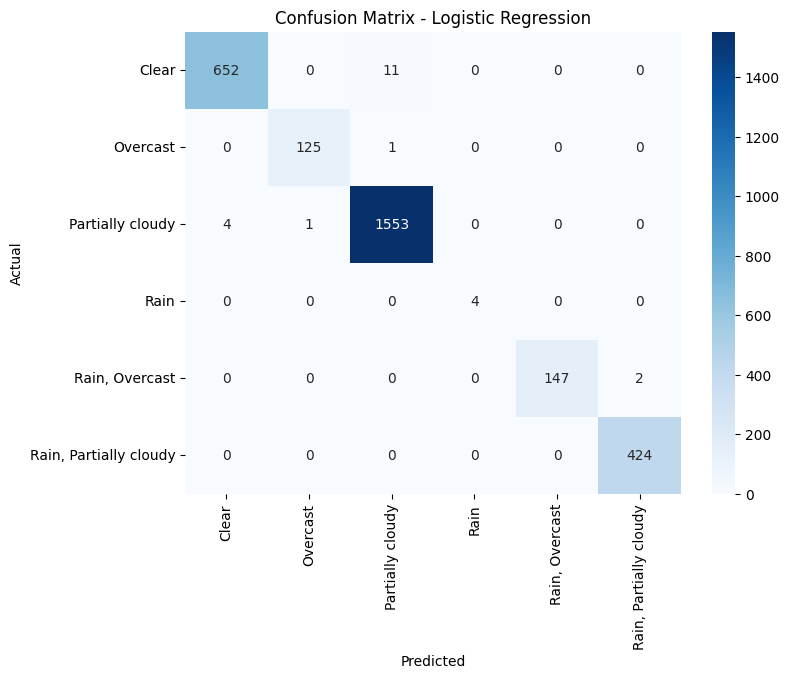

In [226]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [227]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [228]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [229]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9999
Overcast : 0.9989
Partially cloudy : 0.9997
Rain     : 1.0000
Rain, Overcast : 0.9973
Rain, Partially cloudy : 0.9994
Micro-avg : 0.9997


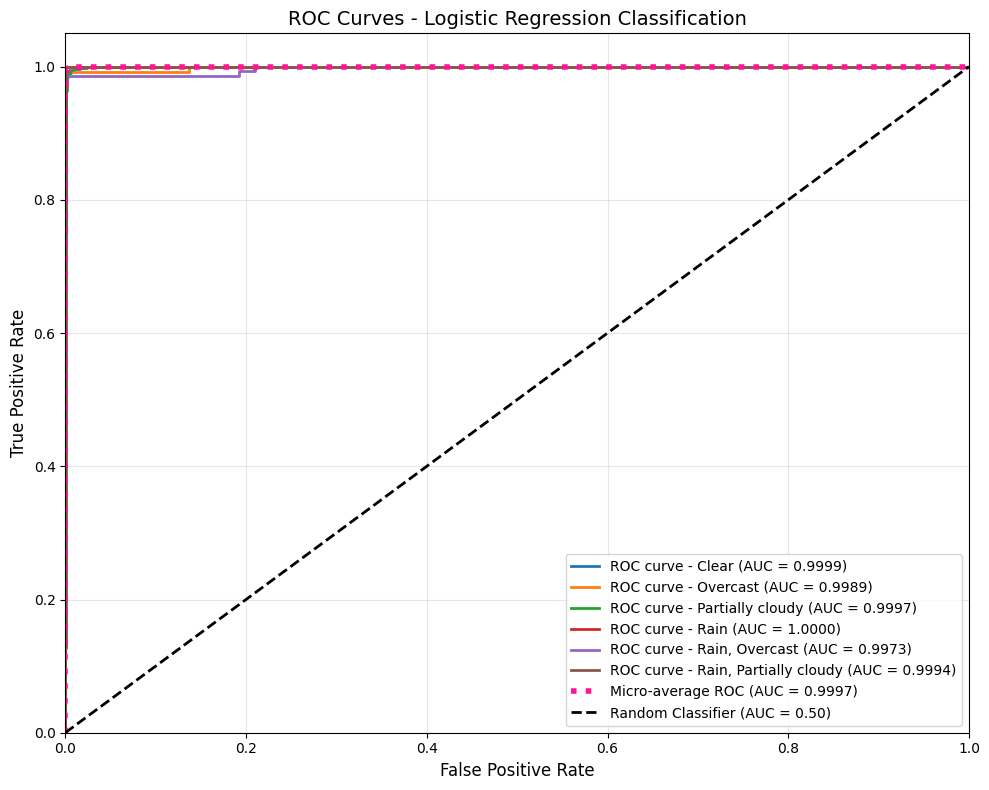

In [230]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [231]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9995
One-vs-One (Weighted)  : 0.9990
Micro-average          : 0.9997


In [232]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.992476 → 0.993502
   F1-Score: 0.992467 → 0.993493
   AUC (micro-avg): 0.999356 → 0.999673
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [233]:
base_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
base_model

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [234]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

,estimator,LGBMClassifie... verbose=0)
,n_estimators,100
,max_samples,1.0
,max_features,0.8
,bootstrap,True
,bootstrap_features,True
,oob_score,False
,warm_start,False
,n_jobs,-1
,random_state,42
,verbose,1


In [235]:
%%time
print("Starting Bagging Ensemble...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    bagging_clf.fit(X_train, y_train)

Starting Bagging Ensemble...
CPU times: total: 5.36 s
Wall time: 1min 5s


In [236]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.7s remaining:    8.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.8s finished


In [237]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [238]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9750
Precision: 0.9759
Recall:    0.9750
F1-Score:  0.9739


In [239]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.97      0.98       663
              Overcast       1.00      0.74      0.85       126
      Partially cloudy       0.97      1.00      0.98      1558
                  Rain       1.00      0.25      0.40         4
        Rain, Overcast       1.00      0.91      0.95       149
Rain, Partially cloudy       0.96      1.00      0.98       424

              accuracy                           0.98      2924
             macro avg       0.99      0.81      0.86      2924
          weighted avg       0.98      0.98      0.97      2924



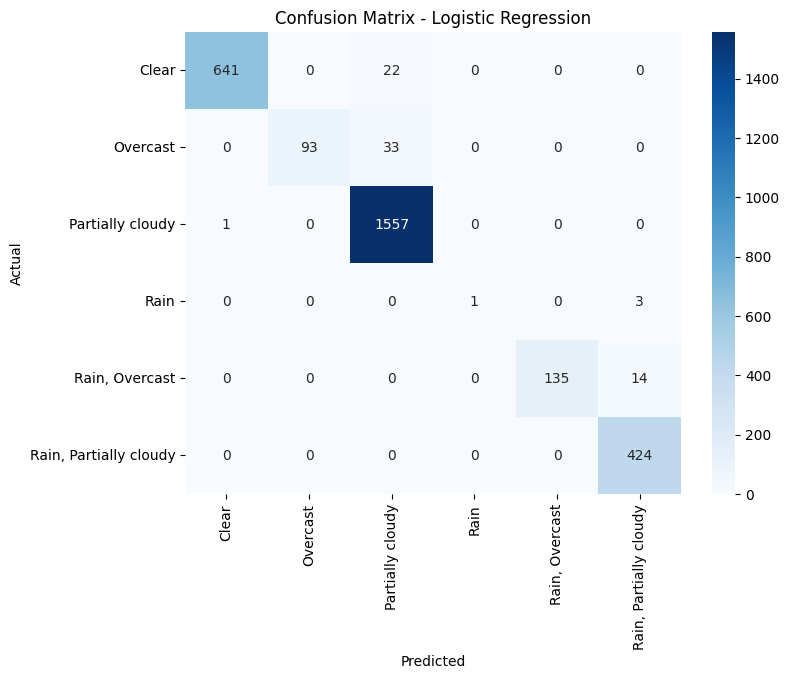

In [240]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [241]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.4s remaining:    7.4s


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.6s finished


In [242]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [243]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9987
Overcast : 0.9999
Partially cloudy : 0.9987
Rain     : 1.0000
Rain, Overcast : 0.9997
Rain, Partially cloudy : 0.9998
Micro-avg : 0.9992


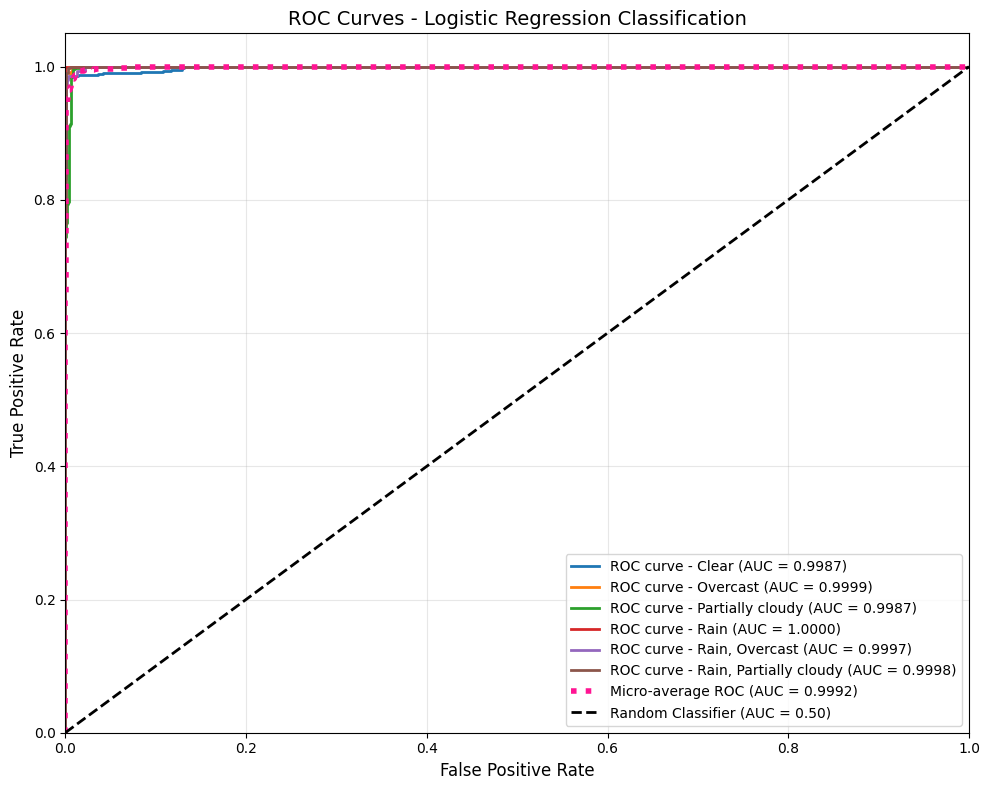

In [244]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [245]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9990
One-vs-One (Weighted)  : 0.9993
Micro-average          : 0.9992


In [246]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "StandardScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

❌ Classification model not improved:
   Current Accuracy: 0.975034, Best Accuracy: 0.993844
   Current F1: 0.973915, Best F1: 0.993832
   Current AUC (micro-avg): 0.999153, Best AUC: 0.999535
   Current Features: 23, Best Features: 27


### Robust Scaler

In [247]:
scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# Convert back to DataFrame to preserve feature names
X_train = pd.DataFrame(X_train_scaled, columns=X_train_raw.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test_raw.columns)

# Clean column names - replace spaces with underscores
X_train.columns = X_train.columns.str.replace(' ', '_')
X_test.columns = X_test.columns.str.replace(' ', '_')

In [248]:
X_train

,Month,Hour,DaySegments_Afternoon,DaySegments_Early_Morning,DaySegments_Evening,DaySegments_Late_Night,DaySegments_Midday,DaySegments_Morning,DaySegments_Night,Season_Autumn,...,Temp,FeelsLike,Dew,Humidity,Precip,PrecipProb,SeaLevelPressure,CloudCover,UVIndex,SevereRisk
0,1.0,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.701322,0.322566,-0.112402,-0.998300,0.0,0.000000,0.002978,-0.040773,0.655031,0.573643
1,-0.2,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.540969,0.459791,0.175196,-0.392181,0.0,0.000000,-0.297841,0.000982,0.000000,22.418605
2,1.4,-1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-1.383260,-0.984629,-0.592151,0.509713,0.0,0.000000,0.520228,-0.253971,0.000000,0.000000
3,-0.2,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.155066,-0.119403,-0.448980,-0.956047,0.0,0.000000,-0.362373,0.162437,0.193018,0.000000
4,-0.8,0.166667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.888106,-0.734239,-0.775510,-0.435406,0.0,0.000000,0.995781,0.619781,1.437372,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11687,1.0,-0.083333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.435242,0.173758,-0.101099,-0.758864,0.0,0.000000,0.553984,-0.822990,1.636550,0.000000
11688,0.8,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.236123,0.403653,0.475353,0.388295,22.0,15.003101,-0.722760,0.255117,0.199179,7.751938
11689,-0.2,-1.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.079295,-0.092671,-0.286970,-0.664157,0.0,0.000000,0.111194,-0.465695,0.000000,0.000000
11690,-0.4,-0.333333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.540969,-0.558699,0.013187,0.523798,0.0,0.000000,0.506329,0.598657,0.404517,-1.961240


In [249]:
X_test

,Month,Hour,DaySegments_Afternoon,DaySegments_Early_Morning,DaySegments_Evening,DaySegments_Late_Night,DaySegments_Midday,DaySegments_Morning,DaySegments_Night,Season_Autumn,...,Temp,FeelsLike,Dew,Humidity,Precip,PrecipProb,SeaLevelPressure,CloudCover,UVIndex,SevereRisk
0,-0.4,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.599119,0.136333,-0.423862,-1.252793,0.0,0.000000,0.517250,-0.467824,1.848049,0.000000
1,0.8,0.916667,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.352423,0.349298,0.279435,-0.104177,4.0,3.000000,-0.496401,0.608646,0.000000,0.251938
2,0.2,0.416667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.378855,0.701270,0.652433,0.524284,2.0,1.500775,-1.000745,0.612248,0.422998,18.755814
3,0.2,0.666667,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.038767,0.075741,0.251805,0.239679,58.0,15.003101,-0.407049,0.582446,0.000000,7.500000
4,-0.2,-0.416667,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.338326,0.417910,0.305808,0.007042,0.0,0.000000,-0.297841,-0.844113,0.404517,1.437984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2919,0.8,-0.583333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.158590,-0.046335,0.407535,0.778776,315.0,15.503876,-0.297841,0.595219,0.000000,-0.089147
2920,0.2,-0.083333,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.872247,0.972154,0.534380,-0.257649,1.0,1.500775,-0.600645,-0.009497,1.827515,7.751938
2921,-0.2,0.583333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.525110,0.286033,-0.020722,-0.717096,0.0,0.500775,0.105237,0.599476,0.000000,-0.437984
2922,0.8,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.181498,0.218311,0.275667,0.085721,0.0,0.000000,-0.300819,0.600950,0.000000,0.751938


#### Default Parameters

In [250]:
training_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
training_model

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [251]:
%%time
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    training_model.fit(X_train, y_train)

CPU times: total: 4.06 s
Wall time: 2.2 s


In [252]:
y_pred = training_model.predict(X_test)
y_pred

array(['Clear', 'Partially cloudy', 'Partially cloudy', ...,
       'Partially cloudy', 'Partially cloudy', 'Partially cloudy'],
      shape=(2924,), dtype=object)

In [253]:
y_test

10500                     Clear
5903           Partially cloudy
12833          Partially cloudy
12476    Rain, Partially cloudy
11527                     Clear
                  ...          
6269     Rain, Partially cloudy
12995          Partially cloudy
2731           Partially cloudy
6164           Partially cloudy
11430          Partially cloudy
Name: Conditions, Length: 2924, dtype: object

In [254]:
accuracy_score_default = accuracy_score(y_test, y_pred)
precision_score_default = precision_score(y_test, y_pred, average='weighted')
recall_score_default = recall_score(y_test, y_pred, average='weighted')
f1_score_default = f1_score(y_test, y_pred, average='weighted')

In [255]:
print(f"Accuracy:  {accuracy_score_default:.4f}")
print(f"Precision: {precision_score_default:.4f}")
print(f"Recall:    {recall_score_default:.4f}")
print(f"F1-Score:  {f1_score_default:.4f}")

Accuracy:  0.9928
Precision: 0.9930
Recall:    0.9928
F1-Score:  0.9929


In [256]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.99      0.99       663
              Overcast       1.00      0.98      0.99       126
      Partially cloudy       0.99      1.00      0.99      1558
                  Rain       0.67      1.00      0.80         4
        Rain, Overcast       1.00      0.99      0.99       149
Rain, Partially cloudy       1.00      1.00      1.00       424

              accuracy                           0.99      2924
             macro avg       0.94      0.99      0.96      2924
          weighted avg       0.99      0.99      0.99      2924



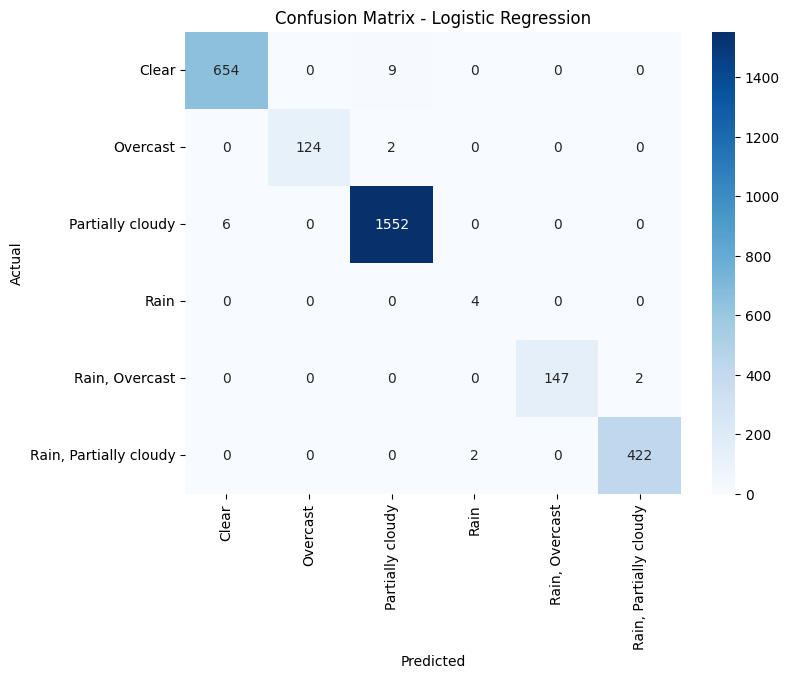

In [257]:
# Use the actual sorted class labels for index and columns
labels = sorted(training_model.classes_)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [258]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = training_model.predict_proba(X_test)
classes = training_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [259]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [260]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9999
Overcast : 0.9984
Partially cloudy : 0.9996
Rain     : 0.9995
Rain, Overcast : 0.9955
Rain, Partially cloudy : 0.9946
Micro-avg : 0.9986


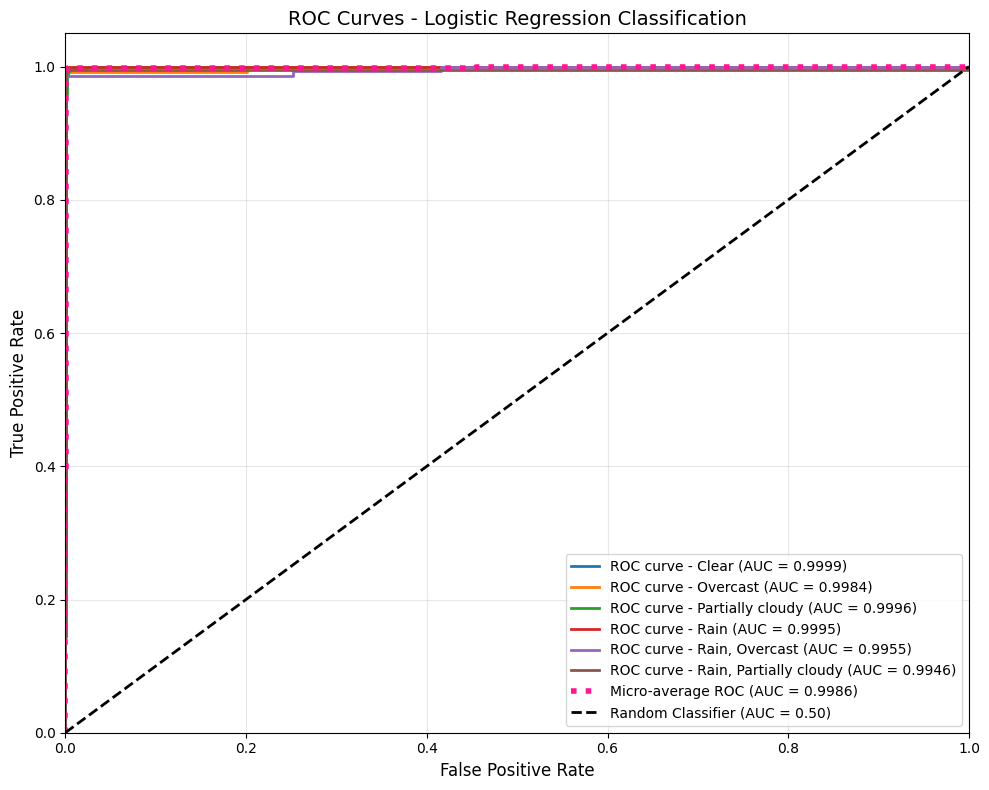

In [261]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [262]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9987
One-vs-One (Weighted)  : 0.9981
Micro-average          : 0.9986


In [263]:
classification_report_dict_for_saving = classification_report(y_test, y_pred, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving,
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(training_model.get_params())
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with same performance but fewer features!
   Accuracy: 0.993502 ≈ 0.992818 (similar)
   F1-Score: 0.993564 ≈ 0.992880 (similar)
   AUC (micro-avg): 0.998673 ≈ 0.998606
   Features: 27 → 23 (🎯 4 fewer features!)
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Tuning with Grid Search

In [264]:
grid_search = RandomizedSearchCV(
    LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass'), 
    grid_param,
    n_iter=number_of_model_for_randomized_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

grid_search

,estimator,LGBMClassifie... verbose=0)
,param_distributions,"{'bagging_fraction': [0.8, 0.9, ...], 'bagging_freq': [0, 1, ...], 'feature_fraction': [0.8, 0.9, ...], 'learning_rate': [0.01, 0.05, ...], ...}"
,n_iter,350
,scoring,'f1_weighted'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [265]:
%%time
print("Starting Grid Search...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    grid_search.fit(X_train, y_train)

Starting Grid Search...
CPU times: total: 15 s
Wall time: 15min 51s


In [266]:
# Get best model and results
best_grid_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("GRID SEARCH RESULTS")
print("="*60)
print("Best Parameters:", best_params)
print("Best Cross-Validation Score:", best_score)

GRID SEARCH RESULTS
Best Parameters: {'subsample_for_bin': 300000, 'reg_lambda': 0.5, 'reg_alpha': 0.0, 'num_leaves': 50, 'n_estimators': 300, 'min_split_gain': 0.0, 'min_child_weight': 0.001, 'min_child_samples': 100, 'max_depth': 10, 'learning_rate': 0.2, 'feature_fraction': 1.0, 'bagging_freq': 0, 'bagging_fraction': 1.0}
Best Cross-Validation Score: 0.9958408022523813


In [267]:
y_pred_grid = best_grid_model.predict(X_test)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [268]:
accuracy_score_grid = accuracy_score(y_test, y_pred_grid)
precision_score_grid = precision_score(y_test, y_pred_grid, average='weighted')
recall_score_grid = recall_score(y_test, y_pred_grid, average='weighted')
f1_score_grid = f1_score(y_test, y_pred_grid, average='weighted')

In [269]:
print(f"Accuracy:  {accuracy_score_grid:.4f}")
print(f"Precision: {precision_score_grid:.4f}")
print(f"Recall:    {recall_score_grid:.4f}")
print(f"F1-Score:  {f1_score_grid:.4f}")

Accuracy:  0.9949
Precision: 0.9949
Recall:    0.9949
F1-Score:  0.9949


In [270]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_grid))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       0.99      0.99      0.99       663
              Overcast       1.00      0.99      1.00       126
      Partially cloudy       0.99      1.00      1.00      1558
                  Rain       1.00      1.00      1.00         4
        Rain, Overcast       1.00      0.99      0.99       149
Rain, Partially cloudy       1.00      1.00      1.00       424

              accuracy                           0.99      2924
             macro avg       1.00      0.99      1.00      2924
          weighted avg       0.99      0.99      0.99      2924



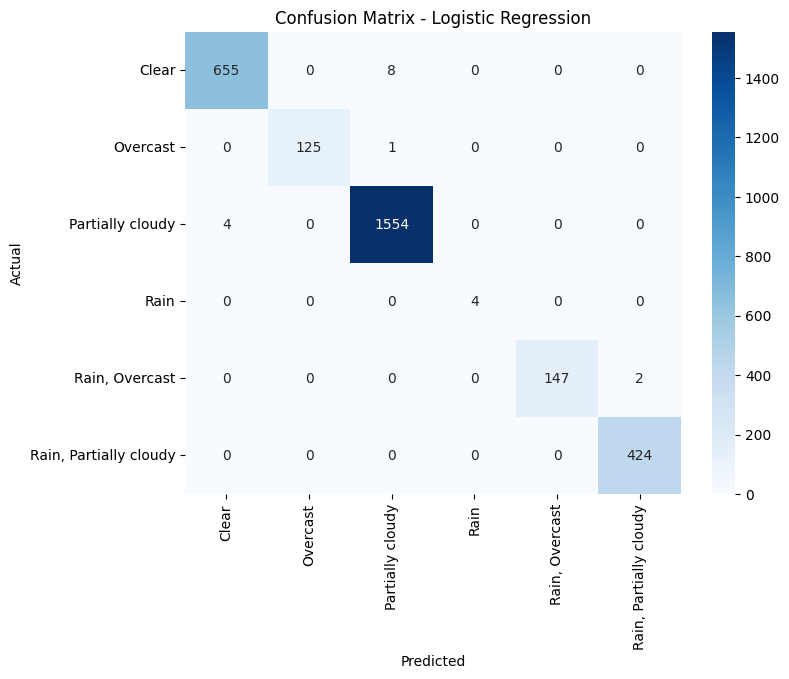

In [271]:
# Use the actual sorted class labels for index and columns
labels = sorted(best_grid_model.classes_)
cm = confusion_matrix(y_test, y_pred_grid, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [272]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = best_grid_model.predict_proba(X_test)
classes = best_grid_model.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


In [273]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [274]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9999
Overcast : 0.9967
Partially cloudy : 0.9995
Rain     : 1.0000
Rain, Overcast : 0.9952
Rain, Partially cloudy : 0.9994
Micro-avg : 0.9994


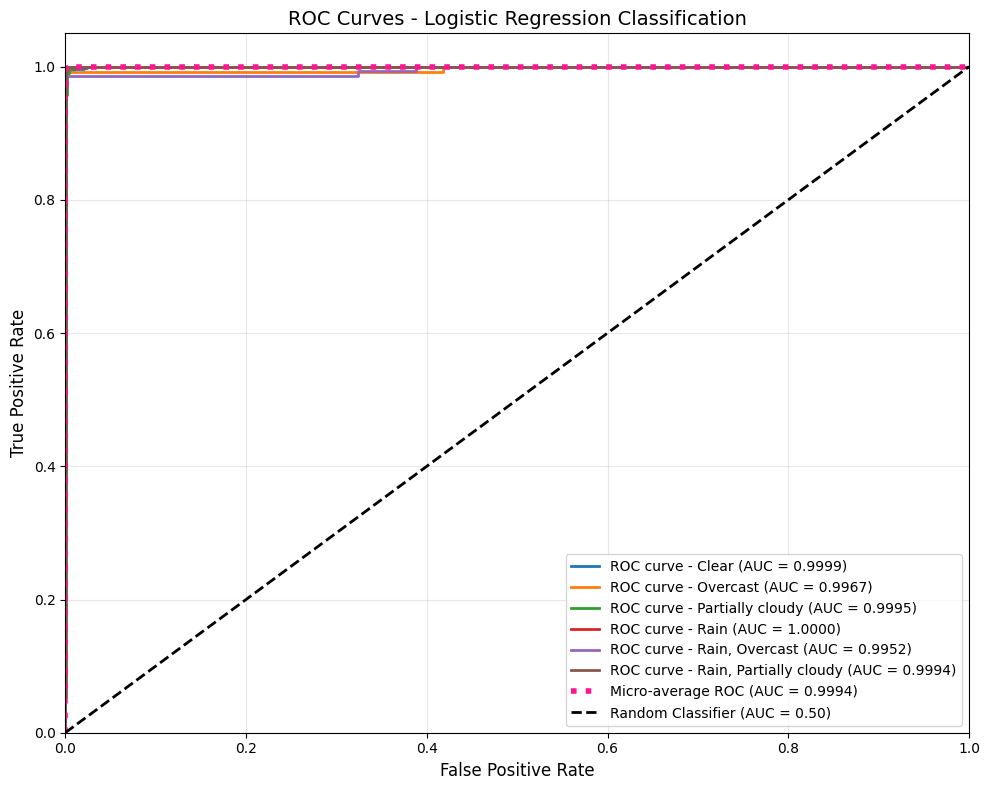

In [275]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [276]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9992
One-vs-One (Weighted)  : 0.9984
Micro-average          : 0.9994


In [277]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_grid, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

classification_params = {
    'model_name': model_name_for_saving + " Grid",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps({
        "best_params": best_params,
        "cv_score": best_score,
        "all_params": best_grid_model.get_params()
    })
}
save_model_performance_if_better('classification', classification_params)

✅ Classification model improved with better performance!
   Accuracy: 0.994186 → 0.994870
   F1-Score: 0.994182 → 0.994865
   AUC (micro-avg): 0.999680 → 0.999425
   Features: 27 → 23
💾 Registry updated: Model_Training_History/History_Classification.csv


#### Ensambling with Bagging

In [278]:
base_model = LGBMClassifier(random_state=42, verbose=0, force_col_wise=True, objective='multiclass')
base_model

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,'multiclass'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [279]:
bagging_clf = BaggingClassifier(
    estimator=base_model,
    n_estimators=number_of_model_for_bagging,
    random_state=42,
    verbose=1,
    n_jobs=-1,
    bootstrap_features=True,
    max_features=0.8
)

bagging_clf

,estimator,LGBMClassifie... verbose=0)
,n_estimators,100
,max_samples,1.0
,max_features,0.8
,bootstrap,True
,bootstrap_features,True
,oob_score,False
,warm_start,False
,n_jobs,-1
,random_state,42
,verbose,1


In [280]:
%%time
print("Starting Bagging Ensemble...")
with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
    bagging_clf.fit(X_train, y_train)

Starting Bagging Ensemble...
CPU times: total: 5.03 s
Wall time: 1min 6s


In [281]:
y_pred_bagging = bagging_clf.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.6s remaining:    8.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    8.0s finished


In [282]:
accuracy_score_bagging = accuracy_score(y_test, y_pred_bagging)
precision_score_bagging = precision_score(y_test, y_pred_bagging, average='weighted')
recall_score_bagging = recall_score(y_test, y_pred_bagging, average='weighted')
f1_score_bagging = f1_score(y_test, y_pred_bagging, average='weighted')

In [283]:
print(f"Accuracy:  {accuracy_score_bagging:.4f}")
print(f"Precision: {precision_score_bagging:.4f}")
print(f"Recall:    {recall_score_bagging:.4f}")
print(f"F1-Score:  {f1_score_bagging:.4f}")

Accuracy:  0.9733
Precision: 0.9730
Recall:    0.9733
F1-Score:  0.9715


In [284]:
print("\nDETAILED CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_test, y_pred_bagging))


DETAILED CLASSIFICATION REPORT
                        precision    recall  f1-score   support

                 Clear       1.00      0.98      0.99       663
              Overcast       1.00      0.71      0.83       126
      Partially cloudy       0.97      1.00      0.98      1558
                  Rain       0.00      0.00      0.00         4
        Rain, Overcast       1.00      0.86      0.92       149
Rain, Partially cloudy       0.94      1.00      0.97       424

              accuracy                           0.97      2924
             macro avg       0.82      0.76      0.78      2924
          weighted avg       0.97      0.97      0.97      2924



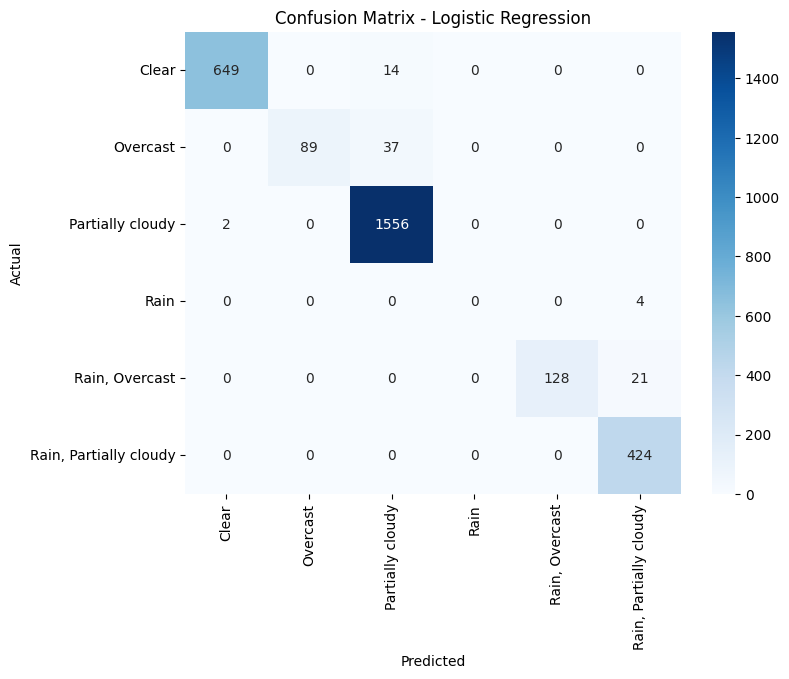

In [285]:
# Use the actual sorted class labels for index and columns
labels = sorted(bagging_clf.classes_)
cm = confusion_matrix(y_test, y_pred_bagging, labels=labels)
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels,
            yticklabels=labels)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [286]:
# ROC and AUC Analysis for Multi-class Classification
print("ROC CURVE AND AUC ANALYSIS")
print("="*50)

# Get prediction probabilities for all classes
y_pred_proba = bagging_clf.predict_proba(X_test)
classes = bagging_clf.classes_
n_classes = len(classes)

print(f"Classes: {classes}")
print(f"Prediction probabilities shape: {y_pred_proba.shape}")

ROC CURVE AND AUC ANALYSIS


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.6s remaining:    8.1s


Classes: ['Clear' 'Overcast' 'Partially cloudy' 'Rain' 'Rain, Overcast'
 'Rain, Partially cloudy']
Prediction probabilities shape: (2924, 6)


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    7.8s finished


In [287]:
# Convert multi-class to binary format for ROC analysis
y_test_bin = label_binarize(y_test, classes=classes)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [288]:
# Print AUC scores
print("\nAUC SCORES:")
print("-" * 30)
for i, class_name in enumerate(classes):
    print(f"{class_name:8} : {roc_auc[i]:.4f}")
print(f"{'Micro-avg':8} : {roc_auc['micro']:.4f}")


AUC SCORES:
------------------------------
Clear    : 0.9992
Overcast : 0.9999
Partially cloudy : 0.9992
Rain     : 1.0000
Rain, Overcast : 0.9996
Rain, Partially cloudy : 0.9998
Micro-avg : 0.9992


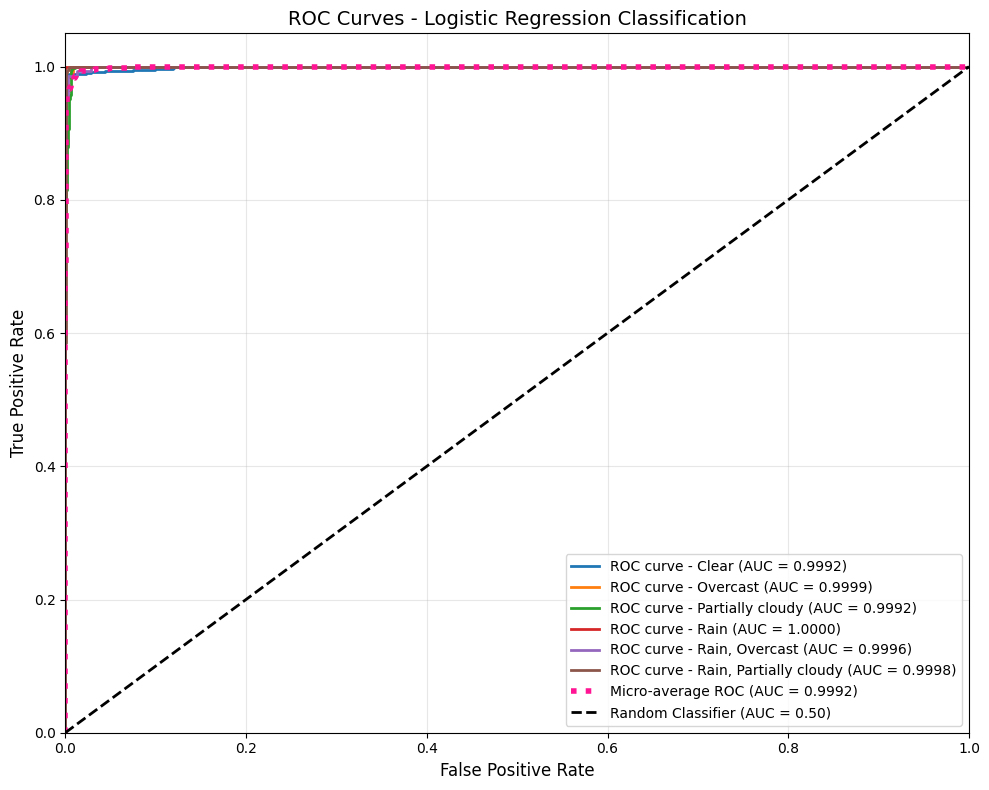

In [289]:
# Plot ROC curves
plt.figure(figsize=(10, 8))

# Colors for different classes
colors = cycle(plt.cm.tab10.colors)

# Plot ROC curve for each class
for i, color, class_name in zip(range(n_classes), colors, classes):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve - {class_name} (AUC = {roc_auc[i]:.4f})')

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC = {roc_auc["micro"]:.4f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.50)')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Logistic Regression Classification', fontsize=14)
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [290]:
# Calculate overall AUC scores using different methods
auc_ovr = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
auc_ovo = roc_auc_score(y_test, y_pred_proba, multi_class='ovo', average='weighted')

print("\nOVERALL AUC SCORES:")
print("-" * 30)
print(f"One-vs-Rest (Weighted) : {auc_ovr:.4f}")
print(f"One-vs-One (Weighted)  : {auc_ovo:.4f}")
print(f"Micro-average          : {roc_auc['micro']:.4f}")


OVERALL AUC SCORES:
------------------------------
One-vs-Rest (Weighted) : 0.9994
One-vs-One (Weighted)  : 0.9995
Micro-average          : 0.9992


In [291]:
classification_report_dict_for_saving = classification_report(y_test, y_pred_bagging, output_dict=True)

auc_score_dict_for_saving = {class_name: roc_auc[i] for i, class_name in enumerate(classes)}
auc_score_dict_for_saving['micro-avg'] = roc_auc['micro']

bagging_params = bagging_clf.get_params()
# Remove the estimator object as it's not JSON serializable
serializable_params = {k: v for k, v in bagging_params.items() if k != 'estimator'}
# Add a description of the estimator instead
serializable_params['estimator_type'] = str(type(bagging_params['estimator']).__name__)
serializable_params['estimator_params'] = bagging_params['estimator'].get_params()

classification_params = {
    'model_name': model_name_for_saving + " Bagging",
    'scaler_name': "RobustScaler",
    'features_list': feature_columns_for_saving,
    'target_column': target_name_for_saving,
    'classification_report_dict': json.dumps(classification_report_dict_for_saving),
    'confusion_matrix_df': cm_df.to_json(),
    'auc_score_dict': json.dumps(auc_score_dict_for_saving),
    'parameters': json.dumps(serializable_params)
}
save_model_performance_if_better('classification', classification_params)

❌ Classification model not improved:
   Current Accuracy: 0.973324, Best Accuracy: 0.994186
   Current F1: 0.971517, Best F1: 0.994196
   Current AUC (micro-avg): 0.999207, Best AUC: 0.999601
   Current Features: 23, Best Features: 27


# All Performance

In [292]:
show_model_history('classification', model_name=model_name_for_saving, target_column=target_name_for_saving)


📊 CLASSIFICATION Model Performance History
            Model         Scaler     Target  Features Accuracy Precision   Recall F1-Score
   Light GBM Grid   RobustScaler Conditions        23 0.994870  0.994875 0.994870 0.994865
        Light GBM StandardScaler Conditions        23 0.994186  0.994422 0.994186 0.994247
Light GBM Bagging   RobustScaler Conditions        27 0.994186  0.994274 0.994186 0.994196
Light GBM Bagging StandardScaler Conditions        27 0.993844  0.993873 0.993844 0.993832
   Light GBM Grid StandardScaler Conditions        23 0.993502  0.993509 0.993502 0.993493
        Light GBM   RobustScaler Conditions        23 0.992818  0.993049 0.992818 0.992880
   Light GBM Grid   MinMaxScaler Conditions        23 0.992476  0.992578 0.992476 0.992479
Light GBM Bagging   MinMaxScaler Conditions        27 0.992476  0.992542 0.992476 0.992454
        Light GBM   MinMaxScaler Conditions        23 0.991792  0.992025 0.991792 0.991849

📈 Total models shown: 9
🏆 Best F1-Score: 0.99

# <center><font size="50" color="red">Thank You</font></center>